# Import and set colors

In [1]:
import scanpy as sc
import anndata as ann
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import cm, colors
from gprofiler import gprofiler

import os 
#doublet detection
import scrublet as scr

#external modules
import scanpy.external as sce
#pretty plotting
import seaborn as sb


#R interface
import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

In [2]:
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython


In [3]:
plt.rcParams['figure.figsize']=(4,3) #rescale figures
sc.settings.verbosity = 3
sc.set_figure_params(scanpy=True, dpi=100, dpi_save=300, fontsize=16, color_map='plasma')
sc.logging.print_header()

scanpy==1.7.1 anndata==0.7.6 umap==0.5.1 numpy==1.21.2 scipy==1.8.1 pandas==1.2.3 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.3 pynndescent==0.5.4


In [4]:
%%R
# Load libraries from correct lib Paths for my environment - ignore this!
#.libPaths(.libPaths()[c(3,2,1)])

# Load all the R libraries we will be using in the notebook
library(scran)
library(RColorBrewer)
library(DropletUtils)



In [5]:
#Define a nice colour map for gene expression
colors2 = plt.cm.plasma(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap2 = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

# Set project file paths

We set up the file paths to the respective directories.

In [6]:
pwd

'/Volumes/bzb/JN/Jovica/Manuscript_CK_VS/notebooks/Read_data_QC'

In [7]:
file_path = '/Volumes/Seagate_Exp/Paper_sc_analysis/' 
#this is my file path please adapt it to your directory

The data directory contains all processed data and `anndata` files. 

In [19]:
matrix= file_path + 'rawdata/raw_data_paper/' 

In [9]:
data_dir =  '/Volumes/bzb/JN/Jovica/Manuscript_CK_VS/notebooks/Read_data_QC/' 

In [10]:
data_dir

'/Volumes/bzb/JN/Jovica/Manuscript_CK_VS/notebooks/Read_data_QC/'

The tables directory contains all tabular data output, e.g. in `.csv` or `.xls` file format. That applies to differential expression test results or overview tables such as the number of cells per cell type.

In [11]:
table_dir = file_path + 'tables_earlytp/'

The default figure path is a POSIX path calles 'figures'. If you don't change the default figure directory, scanpy creates a subdirectory where this notebook is located.  

In [12]:
sc.settings.figdir = file_path + 'figures_earlytp/'

**Comment:** When you repeat certain analyses, it might be helpful to set a date variable and add it to every figure and table (see `datetime` Python package).

In [13]:
import datetime

today = datetime.date.today().strftime('%y%m%d') #creates a YYMMDD string of today's date

# Reading in the data

In [14]:
matrix

'/Volumes/Seagate_Exp/Paper_sc_analysis/rawdata/raw_data_paper'

In [20]:
# Set up data loading
#Explanation directory of one sample '/Volumes/Seagate_Exp/Single_cell_112020/Data/MUC13721_3dDMSO'
#Data files 
sample_strings = ['5dpi_CTRL','5dpi_INH', 'INT',
                  'INT', '3dpi_CTRL', '3dpi_CTRL', '3dpi_INH',
                 '3dpi_INH', 'INT', '5dpi_CTRL', 
                 '5dpi_INH', '5dpi_INH', 'INT', 'INT', '5dpi_CTRL', ]


sample_id_strings = ['21L008532', '21L008533', 'MUC29190','MUC13721', 'MUC13722', 'MUC13723', 'MUC13724', 'MUC13725',  'MUC13726', 'MUC13727', 'MUC13729', 'MUC13730',
                    'MUC13731', 'MUC13732', 'MUC13715']

file_base = matrix

data_file_end = '_matrix.mtx.gz'
barcode_file_end = '_barcodes.tsv.gz'
gene_file_end = '_features.tsv.gz'



In [21]:
# First data set load & annotation
#Parse Filenames
sample = sample_strings.pop(0)
sample_id = sample_id_strings.pop(0)
folder = file_base+sample_id+'_'+sample

#Load data
adata = sc.read_10x_mtx(folder, cache=True)

adata.obs['sample'] = [sample_id+'_'+sample]*adata.n_obs
adata.obs['sample_id'] = [sample_id]*adata.n_obs
adata.obs['sample_id_str'] = [sample_id+'_'+sample]*adata.n_obs

... writing an h5ad cache file to speedup reading next time


In [22]:
# Loop to load rest of data sets
for i in range(len(sample_strings)):
    #Parse Filenames
    sample = sample_strings[i]
    sample_id = sample_id_strings[i]
    folder = file_base+sample_id+'_'+sample
    
    #Load data
    adata_tmp = sc.read_10x_mtx(folder, cache=True)
    
    
    #Annotate data
    adata_tmp.obs['sample'] = [sample_id+'_'+sample]*adata_tmp.n_obs
    adata_tmp.obs['sample_id'] = [sample_id]*adata_tmp.n_obs
    adata_tmp.obs['sample_id_str'] = [sample_id+'_'+sample]*adata_tmp.n_obs
    
    # Concatenate to main adata object
    adata_tmp = adata_tmp[:,adata.var_names]
    adata = adata.concatenate(adata_tmp, batch_key='sample')
    adata.obs.drop(columns=['sample'], inplace=True)
    adata.obs_names = [c.split("-")[0] for c in adata.obs_names]
    adata.obs_names_make_unique(join='_')

... writing an h5ad cache file to speedup reading next time
... writing an h5ad cache file to speedup reading next time
... writing an h5ad cache file to speedup reading next time
... writing an h5ad cache file to speedup reading next time
... writing an h5ad cache file to speedup reading next time
... writing an h5ad cache file to speedup reading next time
... writing an h5ad cache file to speedup reading next time
... writing an h5ad cache file to speedup reading next time
... writing an h5ad cache file to speedup reading next time


/opt/anaconda3/envs/sc-tutorial-020321/lib/python3.8/site-packages/anndata/utils.py:111: UserWarning: Suffix used (_[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['CAACCTCGTAGCGTCC_1']
  warnings.warn(


... writing an h5ad cache file to speedup reading next time


/opt/anaconda3/envs/sc-tutorial-020321/lib/python3.8/site-packages/anndata/utils.py:111: UserWarning: Suffix used (_[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['CTGCCTAAGACAGACC_1']
  warnings.warn(


... writing an h5ad cache file to speedup reading next time


/opt/anaconda3/envs/sc-tutorial-020321/lib/python3.8/site-packages/anndata/utils.py:111: UserWarning: Suffix used (_[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['CATCGGGAGTGAACGC_1', 'CTAATGGAGGCTATCT_1', 'GTGCTTCCATCCCACT_1', 'TGGCCAGGTCTGATCA_1', 'TTGGAACGTGTTTGTG_1']
  warnings.warn(


... writing an h5ad cache file to speedup reading next time


/opt/anaconda3/envs/sc-tutorial-020321/lib/python3.8/site-packages/anndata/utils.py:111: UserWarning: Suffix used (_[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['CACCAGGTCCTGCCAT_1', 'CAGCGACTCGCATGAT_1', 'CGGACACCAGCTATTG_1', 'CTTTGCGTCACGAAGG_1', 'GTCTCGTAGTGAAGAG_1']
  warnings.warn(


... writing an h5ad cache file to speedup reading next time


/opt/anaconda3/envs/sc-tutorial-020321/lib/python3.8/site-packages/anndata/utils.py:111: UserWarning: Suffix used (_[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['AGCATACGTGATGTGG_1', 'ATAGACCGTTATTCTC_1', 'CCTCTGATCAAGGTAA_1', 'GCCAAATTCTGACCTC_1', 'GCTTCCAGTCGAACAG_1']
  warnings.warn(


... writing an h5ad cache file to speedup reading next time


/opt/anaconda3/envs/sc-tutorial-020321/lib/python3.8/site-packages/anndata/utils.py:111: UserWarning: Suffix used (_[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['AGCTTGACAAGCGTAG_1', 'ATCCGAAGTGTCTGAT_1', 'ATTGGTGAGAGTTGGC_1', 'CACCACTCATAAAGGT_1', 'CAGCTAAGTTAAGGGC_1']
  warnings.warn(


In [23]:
adata.obs_names_make_unique()

In [24]:
adata.var_names_make_unique()

In [25]:
# Annotate the data sets
print(adata.obs['sample_id_str'].value_counts())

21L008533_5dpi_INH     10000
21L008532_5dpi_CTRL    10000
MUC13715_5dpi_CTRL      8637
MUC29190_INT            7668
MUC13730_5dpi_INH       6429
MUC13729_5dpi_INH       6146
MUC13732_INT            5868
MUC13731_INT            5318
MUC13725_3dpi_INH       4466
MUC13726_INT            3816
MUC13721_INT            3780
MUC13724_3dpi_INH       3072
MUC13722_3dpi_CTRL      2959
MUC13723_3dpi_CTRL      2880
MUC13727_5dpi_CTRL      2794
Name: sample_id_str, dtype: int64


In [26]:
# Checking the total size of the data set
adata.shape

(83833, 27998)

# Split batches and QC cell bases 

In [28]:
set(adata.obs['sample_id_str'])

{'21L008532_5dpi_CTRL',
 '21L008533_5dpi_INH',
 'MUC13715_5dpi_CTRL',
 'MUC13721_INT',
 'MUC13722_3dpi_CTRL',
 'MUC13723_3dpi_CTRL',
 'MUC13724_3dpi_INH',
 'MUC13725_3dpi_INH',
 'MUC13726_INT',
 'MUC13727_5dpi_CTRL',
 'MUC13729_5dpi_INH',
 'MUC13730_5dpi_INH',
 'MUC13731_INT',
 'MUC13732_INT',
 'MUC29190_INT'}

In [29]:
sample_id_str2condition = {
 '21L008532_5dpi_CTRL':'5dpi_CTRL',
 '21L008533_5dpi_INH':'5dpi_INH',
 'MUC29190_INT':'INT',
 'MUC13715_5dpi_CTRL':'5dpi_CTRL',
 'MUC13721_INT':'INT',
 'MUC13722_3dpi_CTRL':'3dpi_CTRL',
 'MUC13723_3dpi_CTRL':'3dpi_CTRL',
 'MUC13724_3dpi_INH':'3dpi_INT',
 'MUC13725_3dpi_INH':'3dpi_INT',
 'MUC13726_INT':'INT',
 'MUC13727_5dpi_CTRL':'5dpi_CTRL',
 'MUC13729_5dpi_INH':'5dpi_INH',
 'MUC13730_5dpi_INH':'5dpi_INH',
 'MUC13731_INT':'INT',
 'MUC13732_INT':"INT"
}

In [30]:
adata.obs['condition'] = adata.obs['sample_id_str'].map(sample_id_str2condition).astype('category')

In [31]:
#dooble check annotation
pd.crosstab(adata.obs['sample_id_str'],adata.obs['condition'])

condition            3dpi_CTRL  3dpi_INT  5dpi_CTRL  5dpi_INH   INT
sample_id_str                                                      
21L008532_5dpi_CTRL          0         0      10000         0     0
21L008533_5dpi_INH           0         0          0     10000     0
MUC13715_5dpi_CTRL           0         0       8637         0     0
MUC13721_INT                 0         0          0         0  3780
MUC13722_3dpi_CTRL        2959         0          0         0     0
MUC13723_3dpi_CTRL        2880         0          0         0     0
MUC13724_3dpi_INH            0      3072          0         0     0
MUC13725_3dpi_INH            0      4466          0         0     0
MUC13726_INT                 0         0          0         0  3816
MUC13727_5dpi_CTRL           0         0       2794         0     0
MUC13729_5dpi_INH            0         0          0      6146     0
MUC13730_5dpi_INH            0         0          0      6429     0
MUC13731_INT                 0         0          0         0  5318
MUC13732_INT                 0         0          0         0  5868
MUC29190_INT                 0         0          0         0  7668

In [51]:
adata_1 = adata[np.in1d(adata.obs['sample_id_str'],['MUC13721_INT','MUC13722_3dpi_CTRL', 'MUC13723_3dpi_CTRL', 'MUC13724_3dpi_INH', 'MUC13725_3dpi_INH'])].copy()
adata_2 = adata[np.in1d(adata.obs['sample_id_str'],['MUC13726_INT', 'MUC13727_5dpi_CTRL', 'MUC13729_5dpi_INH', 'MUC13730_5dpi_INH', 'MUC13731_INT', 'MUC13732_INT'])].copy()
adata_3 = adata[np.in1d(adata.obs['sample_id_str'],['MUC13715_5dpi_CTRL'])].copy()
adata_4 = adata[np.in1d(adata.obs['sample_id_str'],['MUC29190_INT'])].copy()
adata_5 = adata[np.in1d(adata.obs['sample_id_str'],['21L008532_5dpi_CTRL', '21L008533_5dpi_INH'])].copy()

In [34]:
adata.obs['batch'] = 5
batch_3_cells = adata[adata.obs['sample_id_str'].isin(['MUC13721_INT','MUC13722_3dpi_CTRL', 'MUC13723_3dpi_CTRL', 'MUC13724_3dpi_INH', 'MUC13725_3dpi_INH'])].obs_names
adata.obs.loc[batch_3_cells,'batch'] = 1
batch_5a_cells = adata[adata.obs['sample_id_str'].isin(['MUC13726_INT', 'MUC13727_5dpi_CTRL', 'MUC13729_5dpi_INH', 'MUC13730_5dpi_INH', 'MUC13731_INT', 'MUC13732_INT'])].obs_names
adata.obs.loc[batch_5a_cells,'batch'] = 2
batch_5_cells = adata[adata.obs['sample_id_str'].isin(['MUC13715_5dpi_CTRL'])].obs_names
adata.obs.loc[batch_5_cells,'batch'] = 3
batch_28_cells = adata[adata.obs['sample_id_str'].isin([ 'MUC29190_INT'])].obs_names
adata.obs.loc[batch_28_cells,'batch'] = 4
batch_5c_cells = adata[adata.obs['sample_id_str'].isin(['21L008532_5dpi_CTRL', '21L008533_5dpi_INH'])].obs_names
adata.obs.loc[batch_5c_cells,'batch'] = 5
#adata_main_correct.obs[['batch','sample']]
adata.obs['batch'] = adata.obs['batch'].astype('category')

In [35]:
#dooble check annotation
pd.crosstab(adata.obs['sample_id_str'],adata.obs['batch'])

batch                   1     2     3     4      5
sample_id_str                                     
21L008532_5dpi_CTRL     0     0     0     0  10000
21L008533_5dpi_INH      0     0     0     0  10000
MUC13715_5dpi_CTRL      0     0  8637     0      0
MUC13721_INT         3780     0     0     0      0
MUC13722_3dpi_CTRL   2959     0     0     0      0
MUC13723_3dpi_CTRL   2880     0     0     0      0
MUC13724_3dpi_INH    3072     0     0     0      0
MUC13725_3dpi_INH    4466     0     0     0      0
MUC13726_INT            0  3816     0     0      0
MUC13727_5dpi_CTRL      0  2794     0     0      0
MUC13729_5dpi_INH       0  6146     0     0      0
MUC13730_5dpi_INH       0  6429     0     0      0
MUC13731_INT            0  5318     0     0      0
MUC13732_INT            0  5868     0     0      0
MUC29190_INT            0     0     0  7668      0

## Compute quality control metrics

In [36]:
adata_1

AnnData object with n_obs × n_vars = 17157 × 27998
    obs: 'sample_id', 'sample_id_str', 'condition'
    var: 'gene_ids', 'feature_types'

In [37]:
plt.rcParams['figure.figsize']=(4,3)

In [38]:
sc.pp.calculate_qc_metrics(adata, inplace=True)

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [39]:
sc.pp.calculate_qc_metrics(adata, inplace=True)

We further aim to determine the fraction of mitochondrial counts per cell.
Please note that mitochondrial genes in mouse start with 'mt-'

In [40]:
mt_gene_mask = np.flatnonzero([gene.startswith('mt-') for gene in adata.var_names]) #here you need to check how are the mitochondrial genes in zebrafish
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['mt_frac'] = np.sum(adata[:, mt_gene_mask].X, axis=1).A1/adata.obs['total_counts']

Let us visualize the number of expressed genes and the number of counts as a scatter plot. 

... storing 'sample_id' as categorical
... storing 'sample_id_str' as categorical
... storing 'feature_types' as categorical


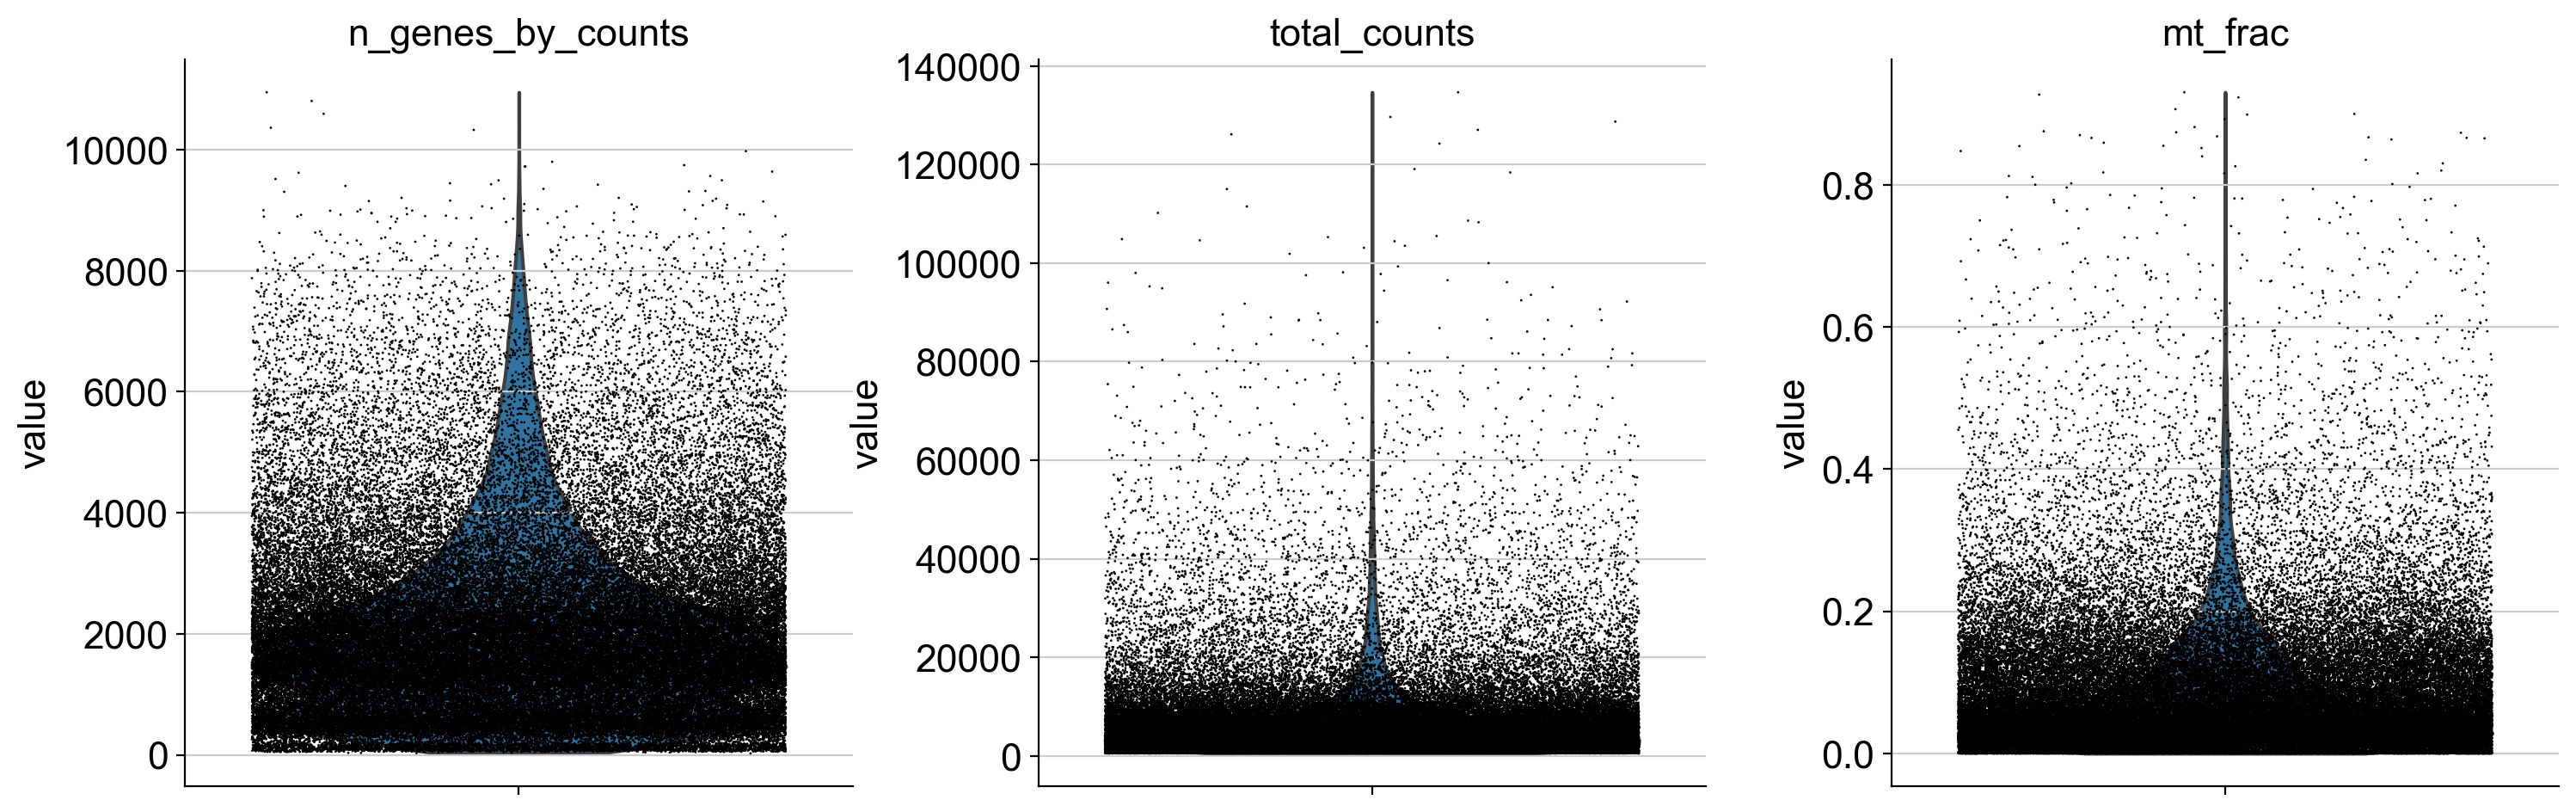

In [41]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'mt_frac'],
             jitter=0.4, multi_panel=True)

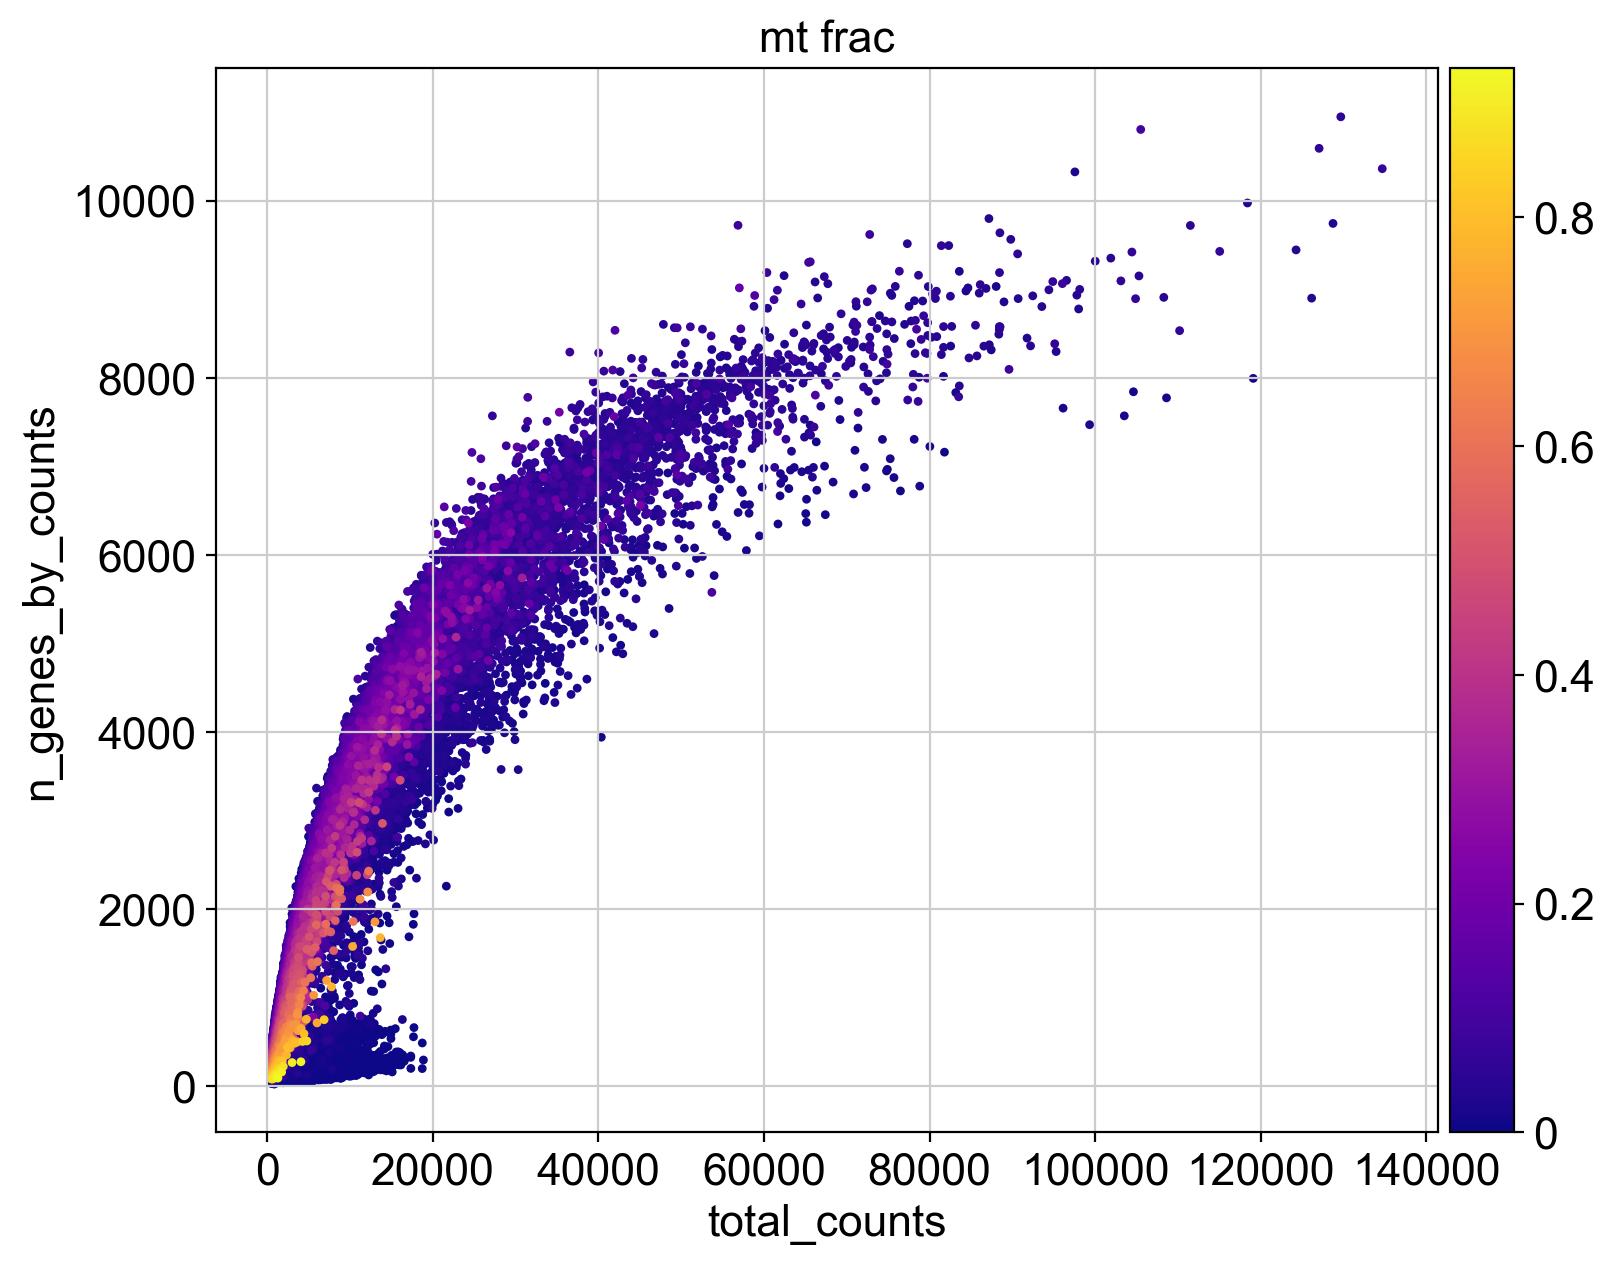

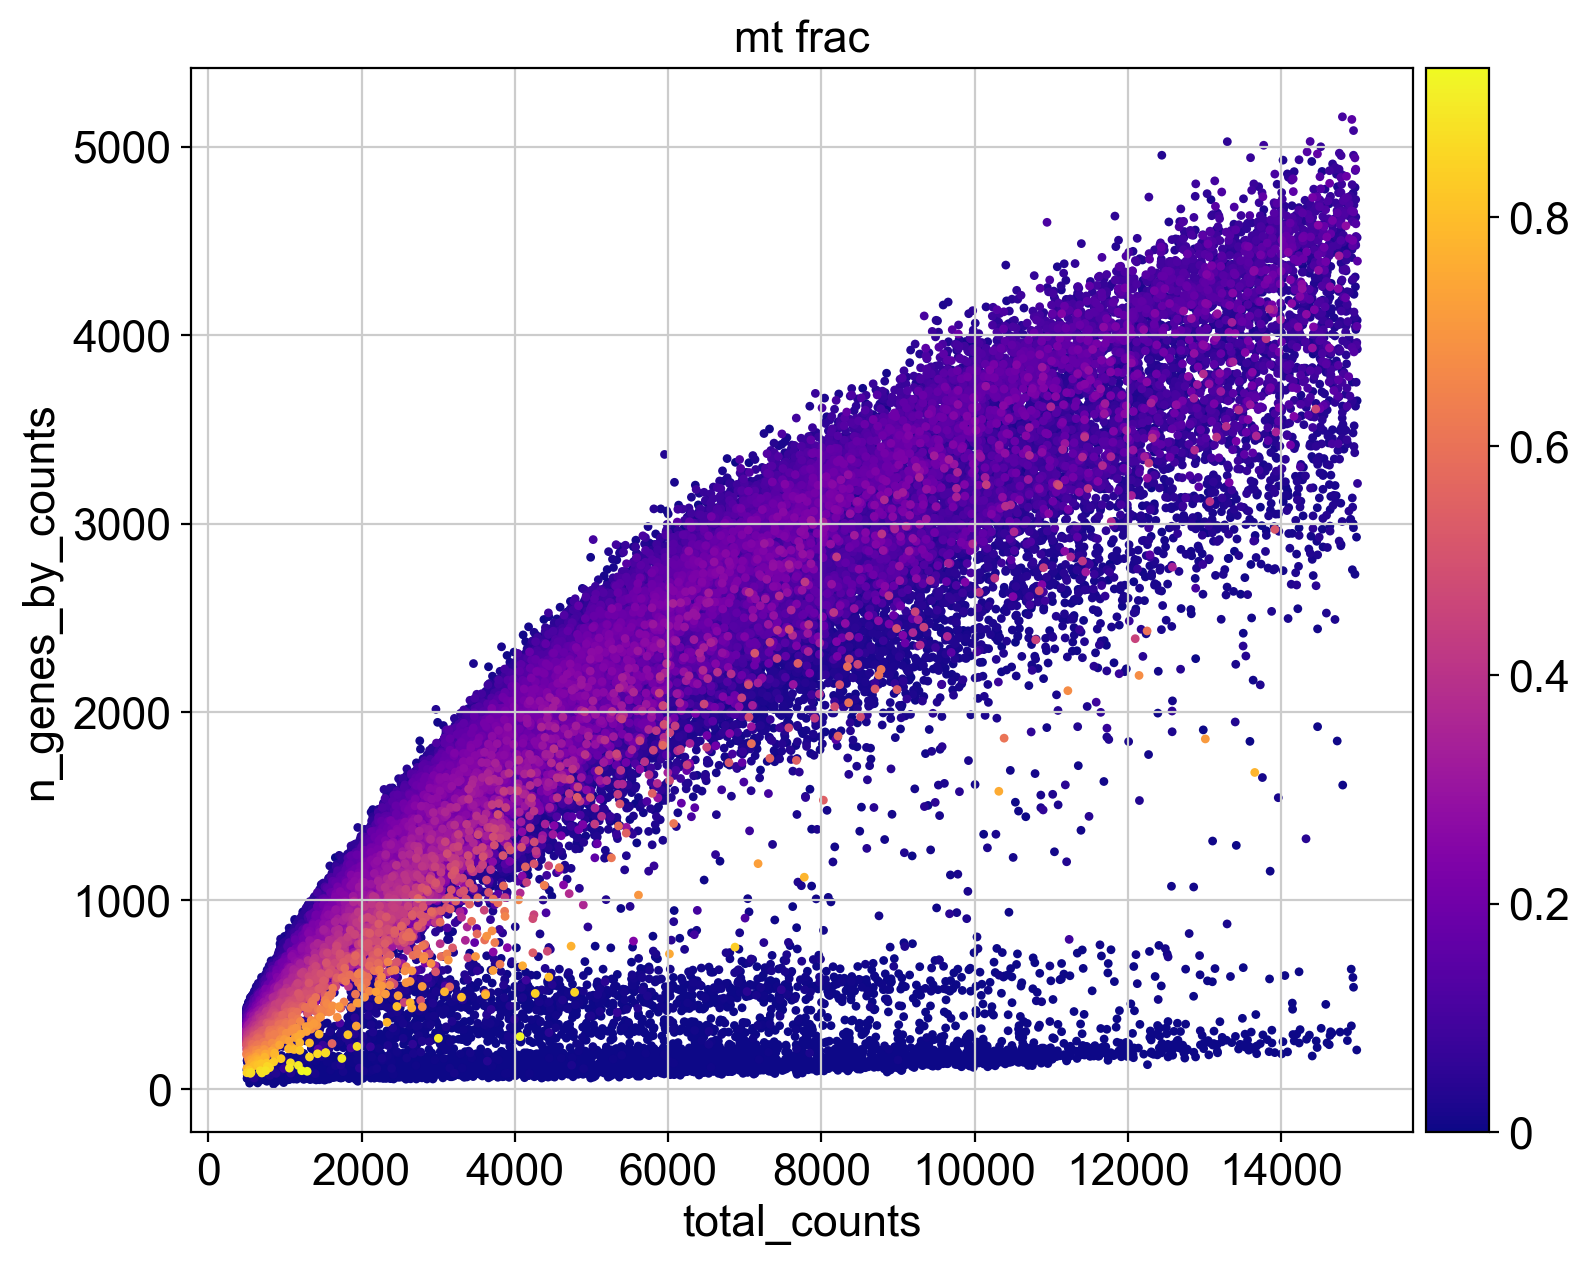

In [42]:
#Data quality summary plots
rcParams['figure.figsize']=(7,7)
p1 = sc.pl.scatter(adata, 'total_counts', 'n_genes_by_counts', color='mt_frac', size=40)
p2 = sc.pl.scatter(adata[adata.obs['total_counts']<15000], 'total_counts', 'n_genes_by_counts', 
                   color='mt_frac', size=40)

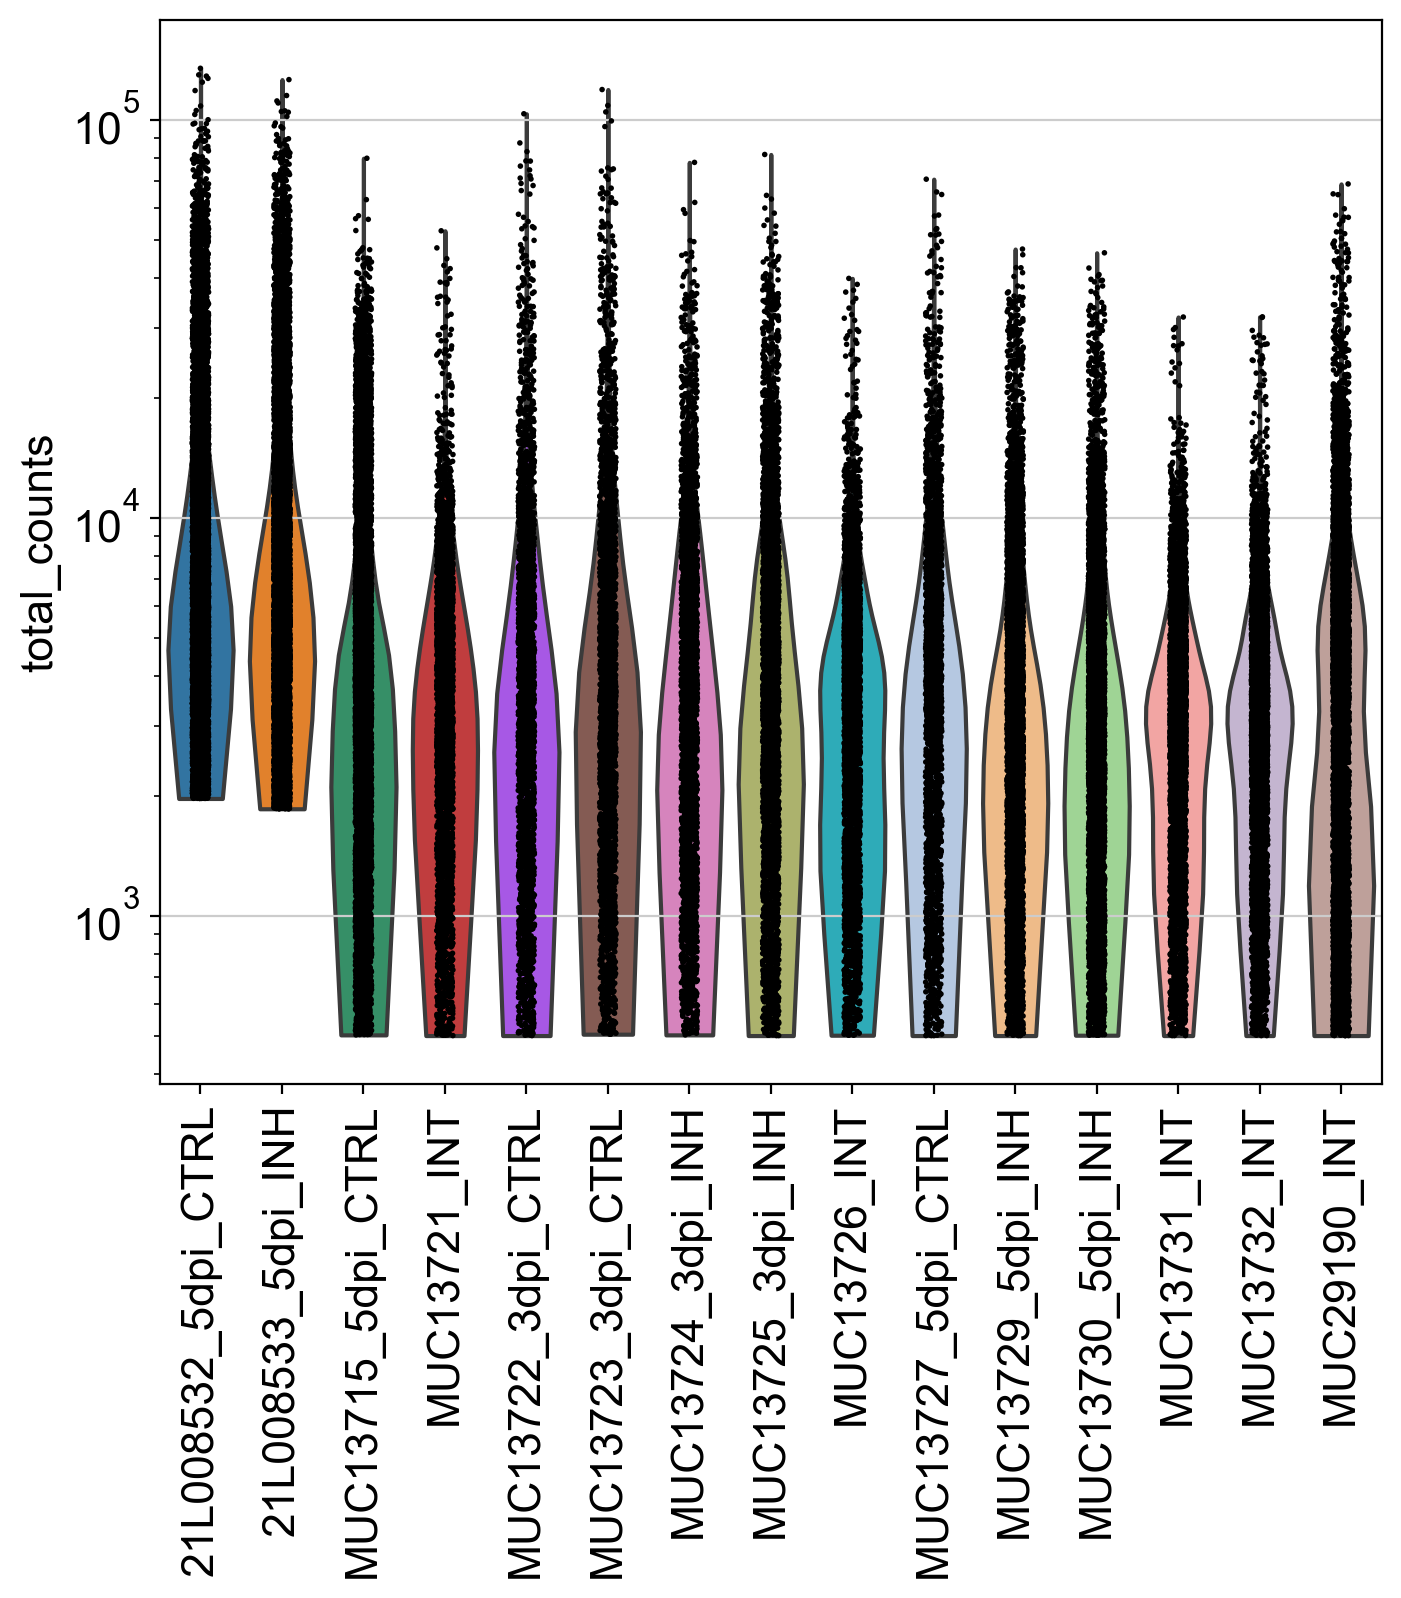

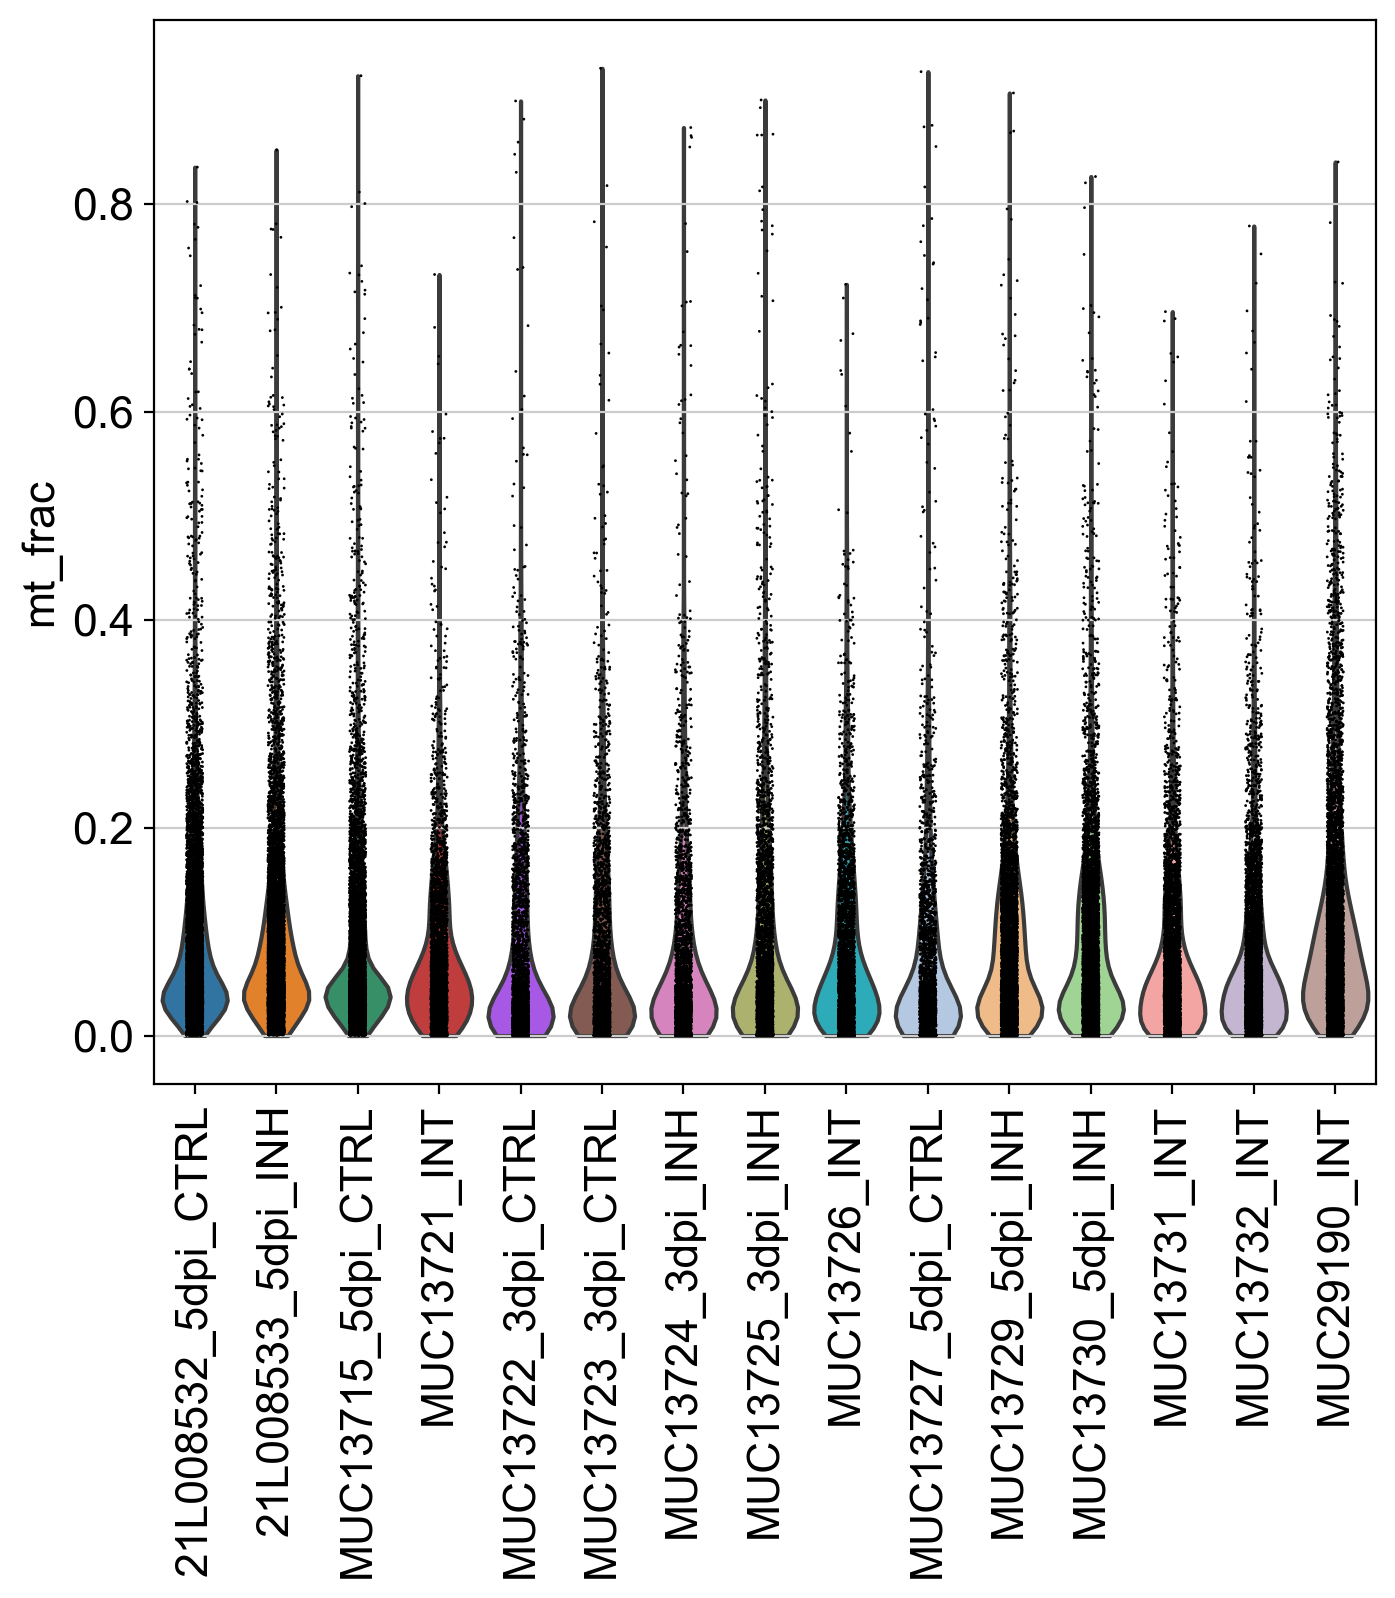

In [43]:
#Sample quality plots
rcParams['figure.figsize']=(7,7) #set figure size
t1 = sc.pl.violin(adata, 'total_counts',rotation=90,
                  groupby='sample_id_str',
                  size=2, log=True, cut=0)
t2 = sc.pl.violin(adata, 'mt_frac',rotation=90,
                  groupby='sample_id_str',)

Examine the overall library complexity. 
Let us plot the top 50 highest expressed genes first.

normalizing counts per cell
    finished (0:00:01)


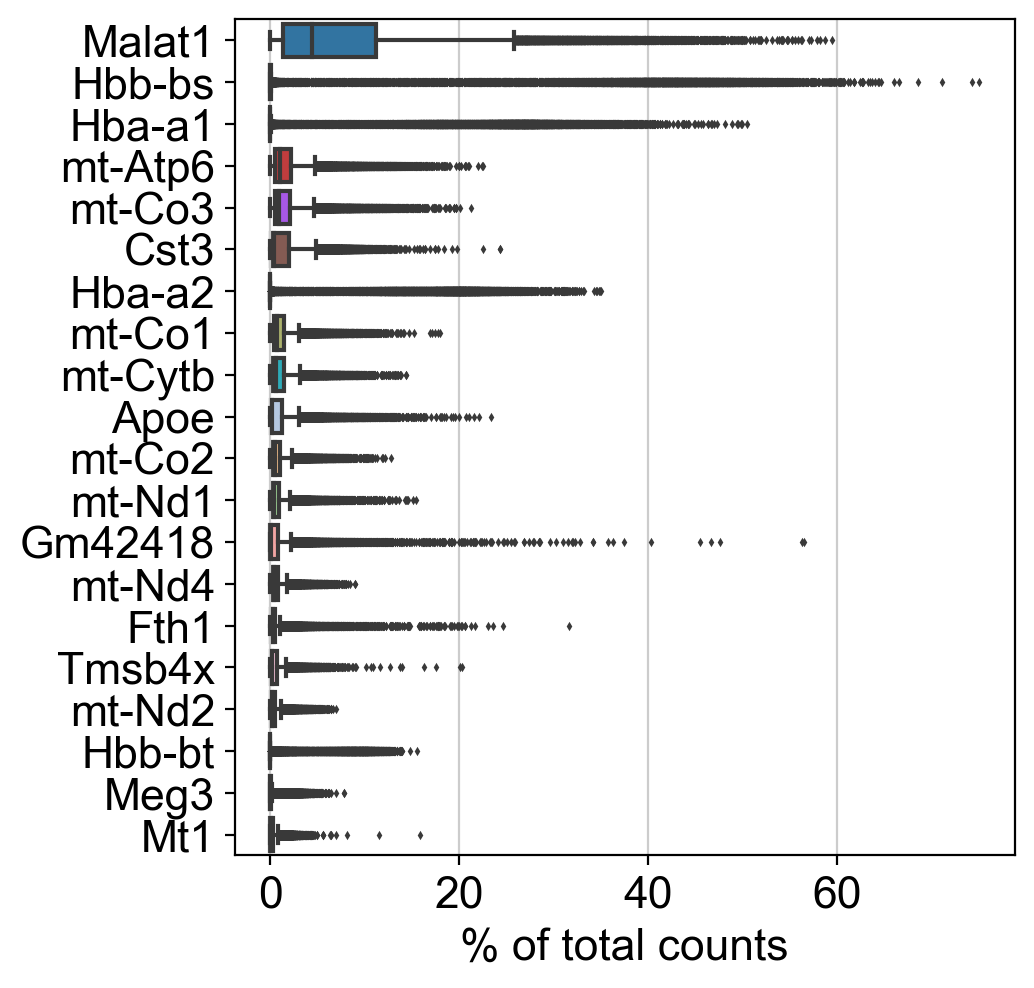

In [44]:
sc.pl.highest_expr_genes(adata, n_top=20)

We expect to see the “usual suspects”, i.e., mitochondrial genes, actin, ribosomal protein, MALAT1. 

How many counts come from the top 50/100/200/500 highest expressed genes? Visualize the fraction as violin plot.

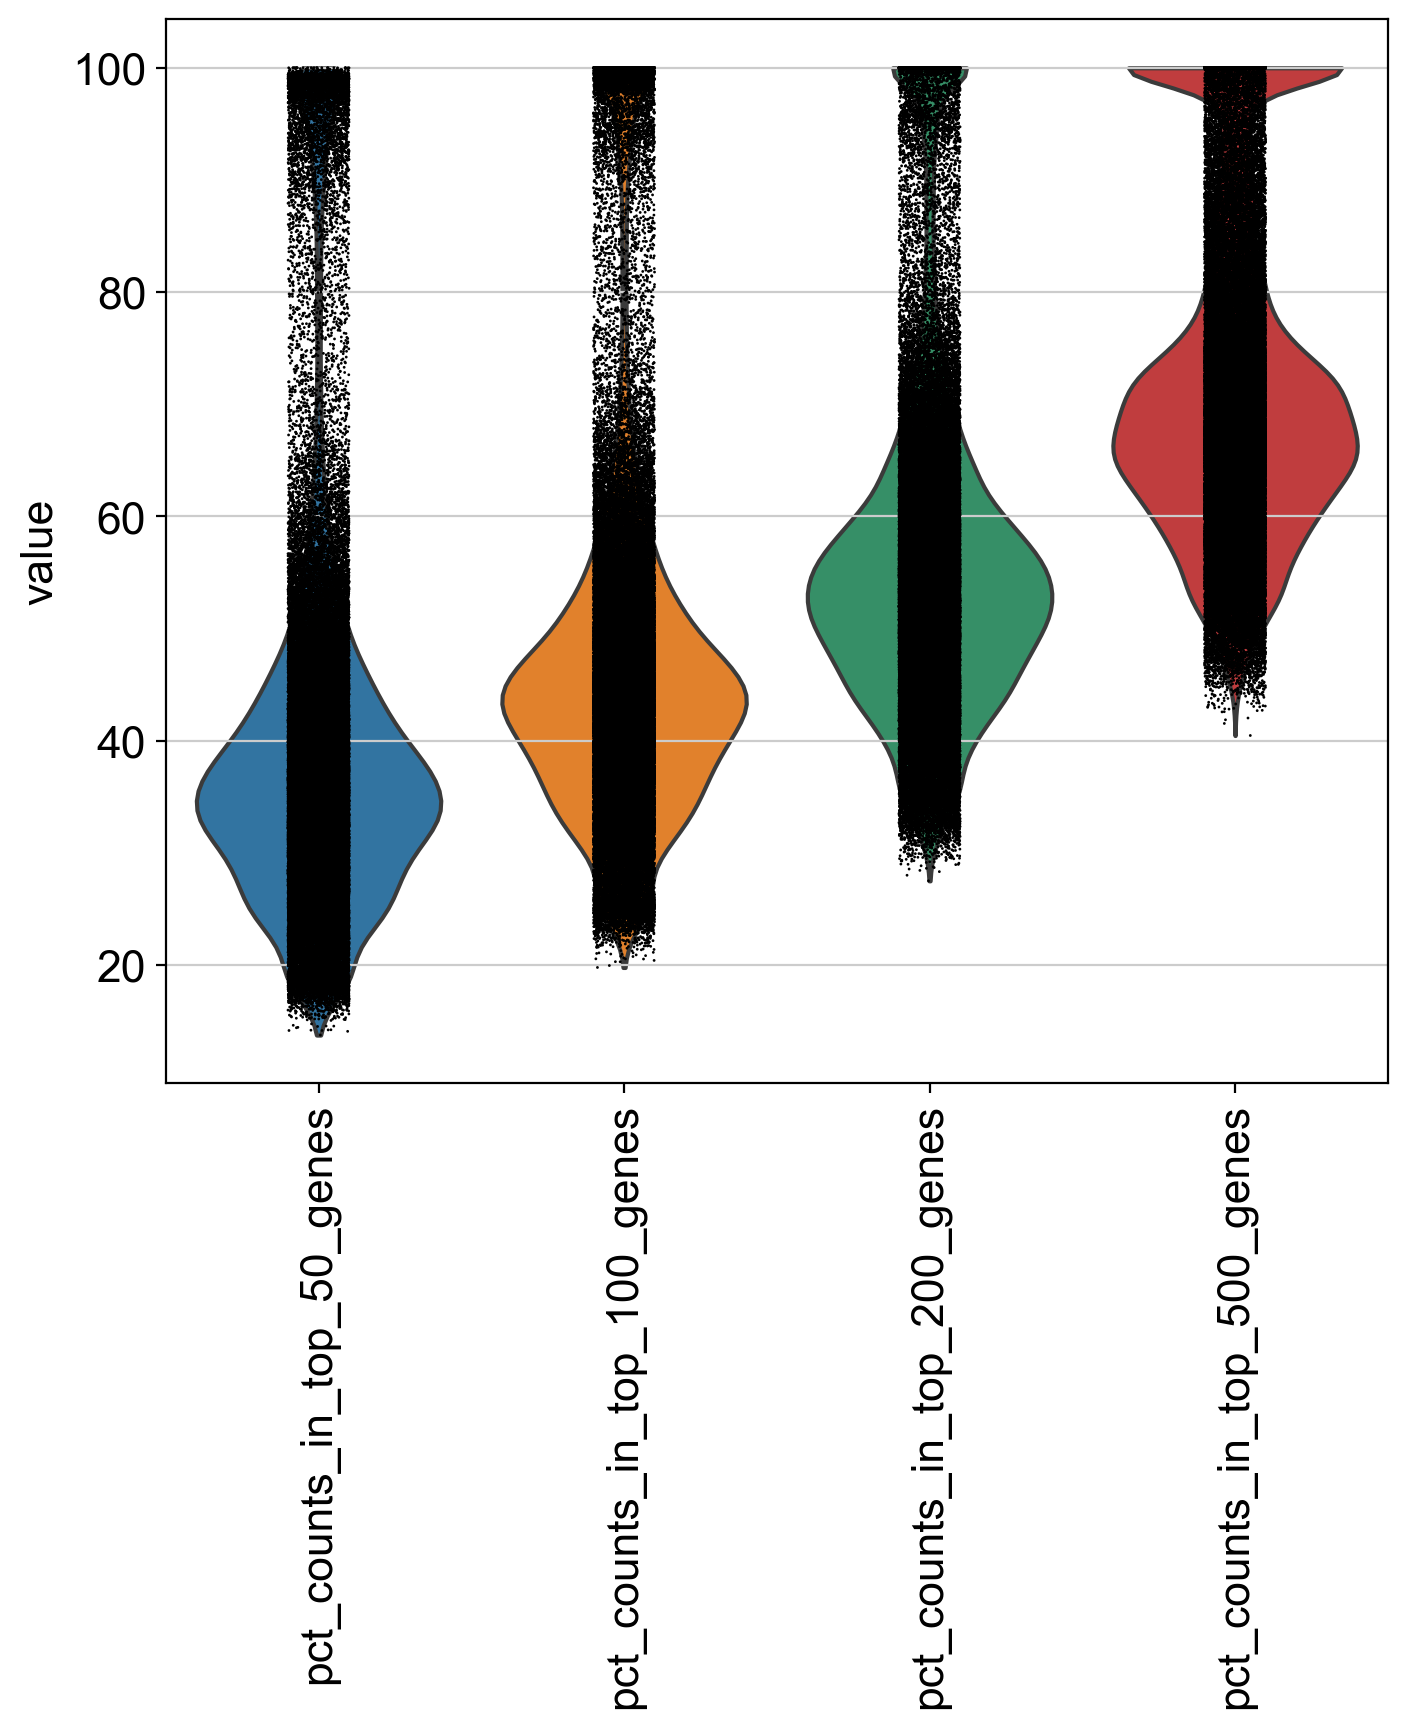

In [45]:
#Sample quality plots
rcParams['figure.figsize']=(7,7) #set figure size
t3 = sc.pl.violin(adata, keys=['pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 
                     'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
                    ], rotation = 90)


**BONUS:** Visualize the log-transformed total counts vs the log-transformed number of expressed genes with distribution plots on the side of each axis.

/opt/anaconda3/envs/sc-tutorial-020321/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


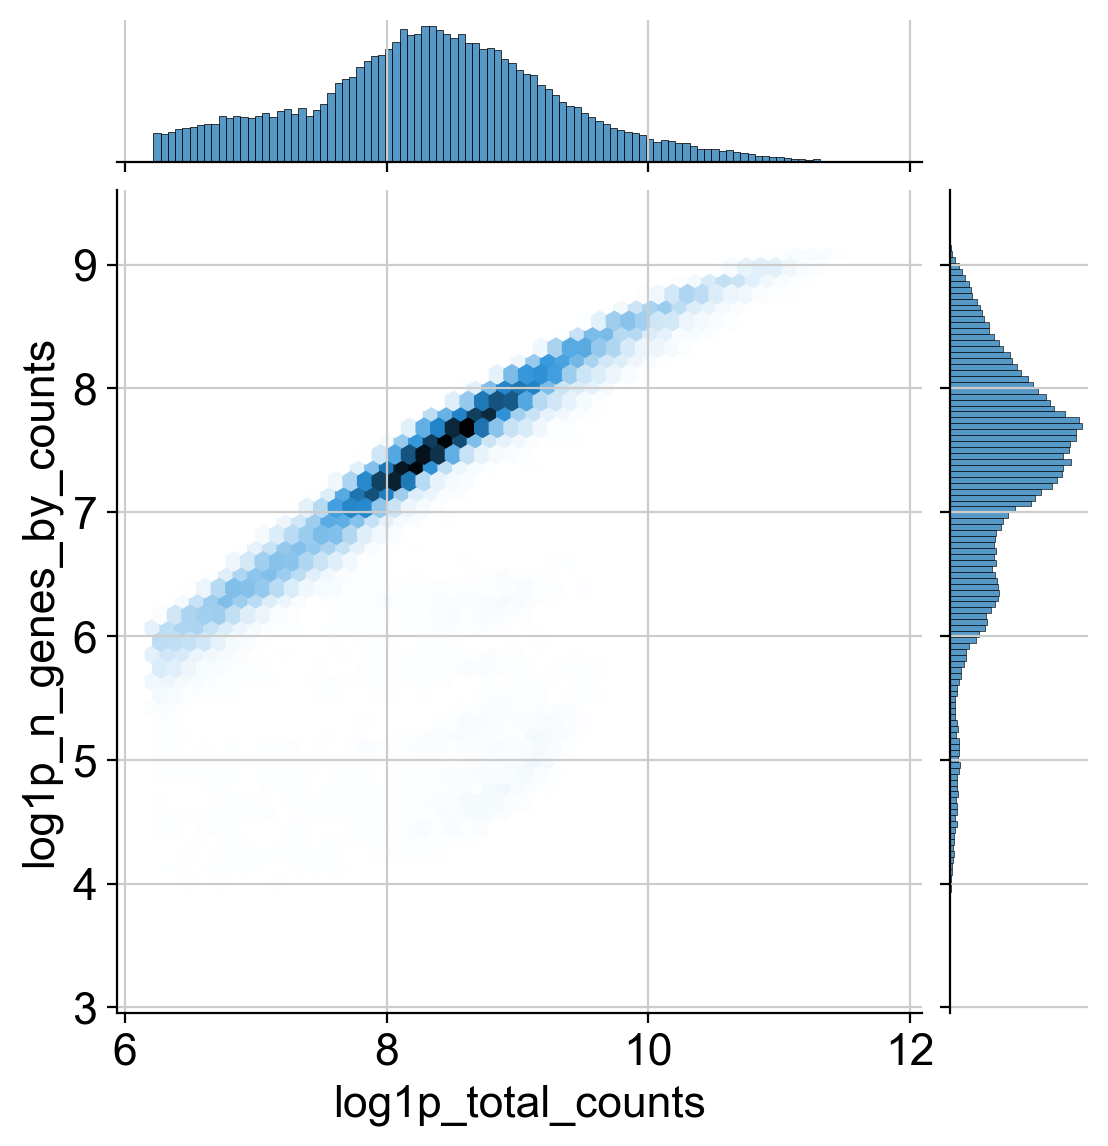

In [46]:
sb.jointplot(
        "log1p_total_counts", 
        "log1p_n_genes_by_counts",
        data=adata.obs, kind="hex"
    )

Create a histogram for the total number of counts. Further, create a histogram for the low count and high count regime, each.

Note: `pandas` does some histogram plotting with `adata.obs['n_counts'].hist()`, however, you will obtain prettier plots with `distplot` from `seaborn`.    

/opt/anaconda3/envs/sc-tutorial-020321/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/sc-tutorial-020321/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/sc-tutorial-020321/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a fi

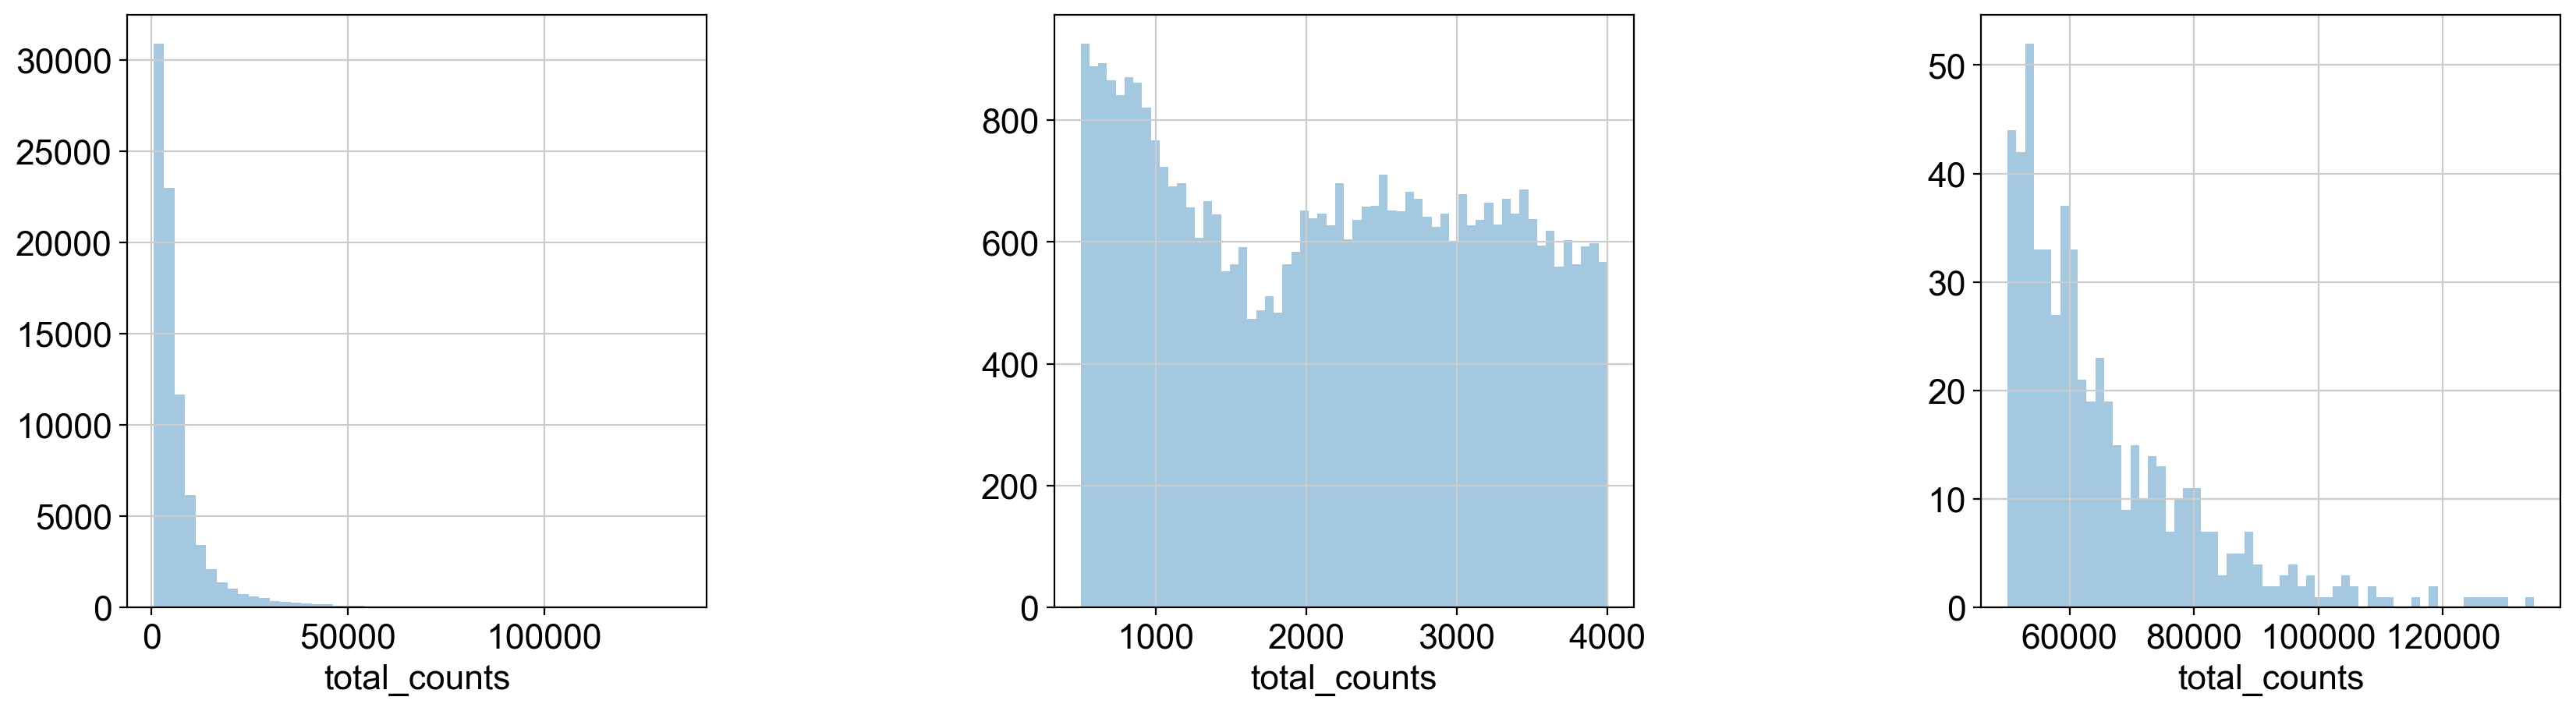

In [47]:
#Thresholding decision: counts
rcParams['figure.figsize']=(20,5)
fig_ind=np.arange(131, 134)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6)

p3 = sb.distplot(adata.obs['total_counts'], 
                 kde=False, 
                 ax=fig.add_subplot(fig_ind[0]))
p4 = sb.distplot(adata.obs['total_counts'][adata.obs['total_counts']<4000], 
                 kde=False, bins=60, 
                 ax=fig.add_subplot(fig_ind[1]))
p5 = sb.distplot(adata.obs['total_counts'][adata.obs['total_counts']>50000], 
                 kde=False, bins=60, 
                 ax=fig.add_subplot(fig_ind[2]))
plt.show()

Create a histogram for the total number of genes. Further, create a histogram for the low gene count and high gene count regime, each.

/opt/anaconda3/envs/sc-tutorial-020321/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


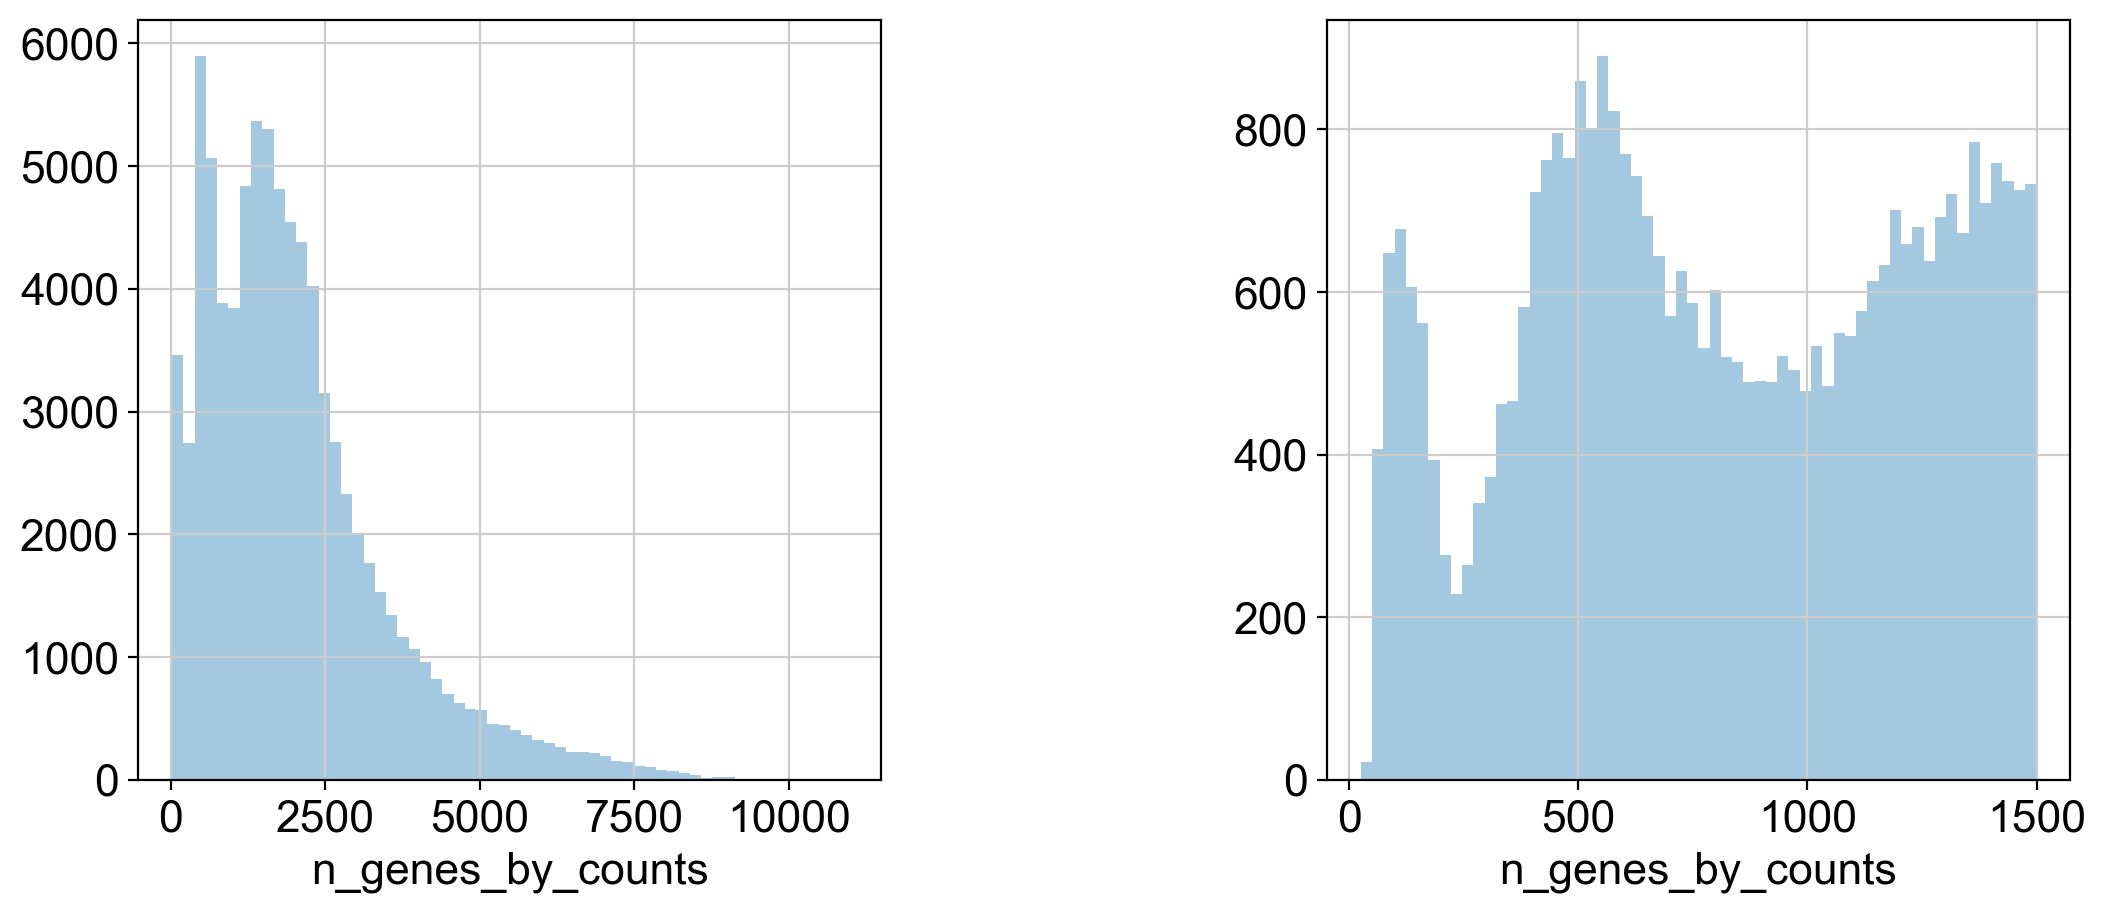

In [48]:
#Thresholding decision: genes

rcParams['figure.figsize']=(20,5)
fig_ind=np.arange(131, 133)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6) #create a grid for subplots

p6 = sb.distplot(adata.obs['n_genes_by_counts'], kde=False, bins=60, ax=fig.add_subplot(fig_ind[0]))

p7 = sb.distplot(adata.obs['n_genes_by_counts'][adata.obs['n_genes_by_counts']<1500], 
                 kde=False, bins=60, ax=fig.add_subplot(fig_ind[1]))
plt.show()

/opt/anaconda3/envs/sc-tutorial-020321/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/sc-tutorial-020321/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/sc-tutorial-020321/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a fi

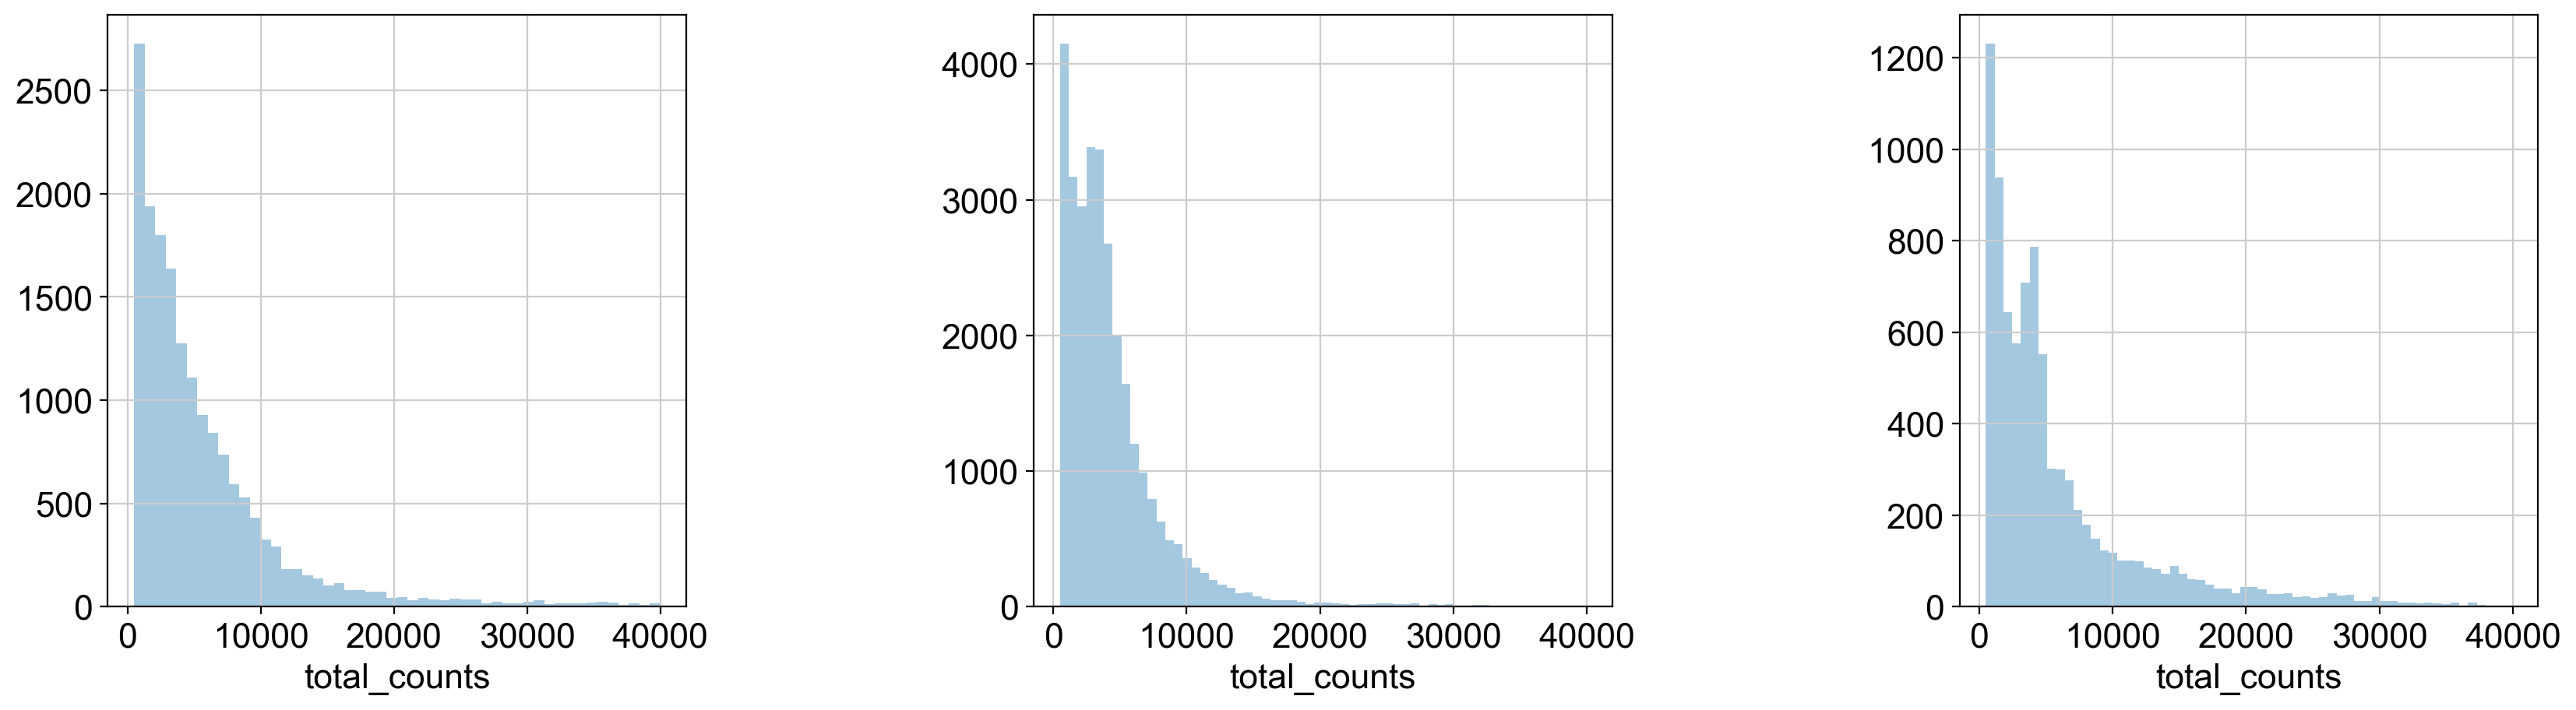

In [52]:
#Thresholding decision: counts
rcParams['figure.figsize']=(20,5)
fig_ind=np.arange(131, 134)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6)

p3 = sb.distplot(adata_1.obs['total_counts'][adata_1.obs['total_counts']<40000], 
                 kde=False, 
                 ax=fig.add_subplot(fig_ind[0]))
p4 = sb.distplot(adata_2.obs['total_counts'][adata_2.obs['total_counts']<40000], 
                 kde=False, bins=60, 
                 ax=fig.add_subplot(fig_ind[1]))
p5 = sb.distplot(adata_3.obs['total_counts'][adata_3.obs['total_counts']<40000], 
                 kde=False, bins=60, 
                 ax=fig.add_subplot(fig_ind[2]))

plt.show()

/opt/anaconda3/envs/sc-tutorial-020321/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/sc-tutorial-020321/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


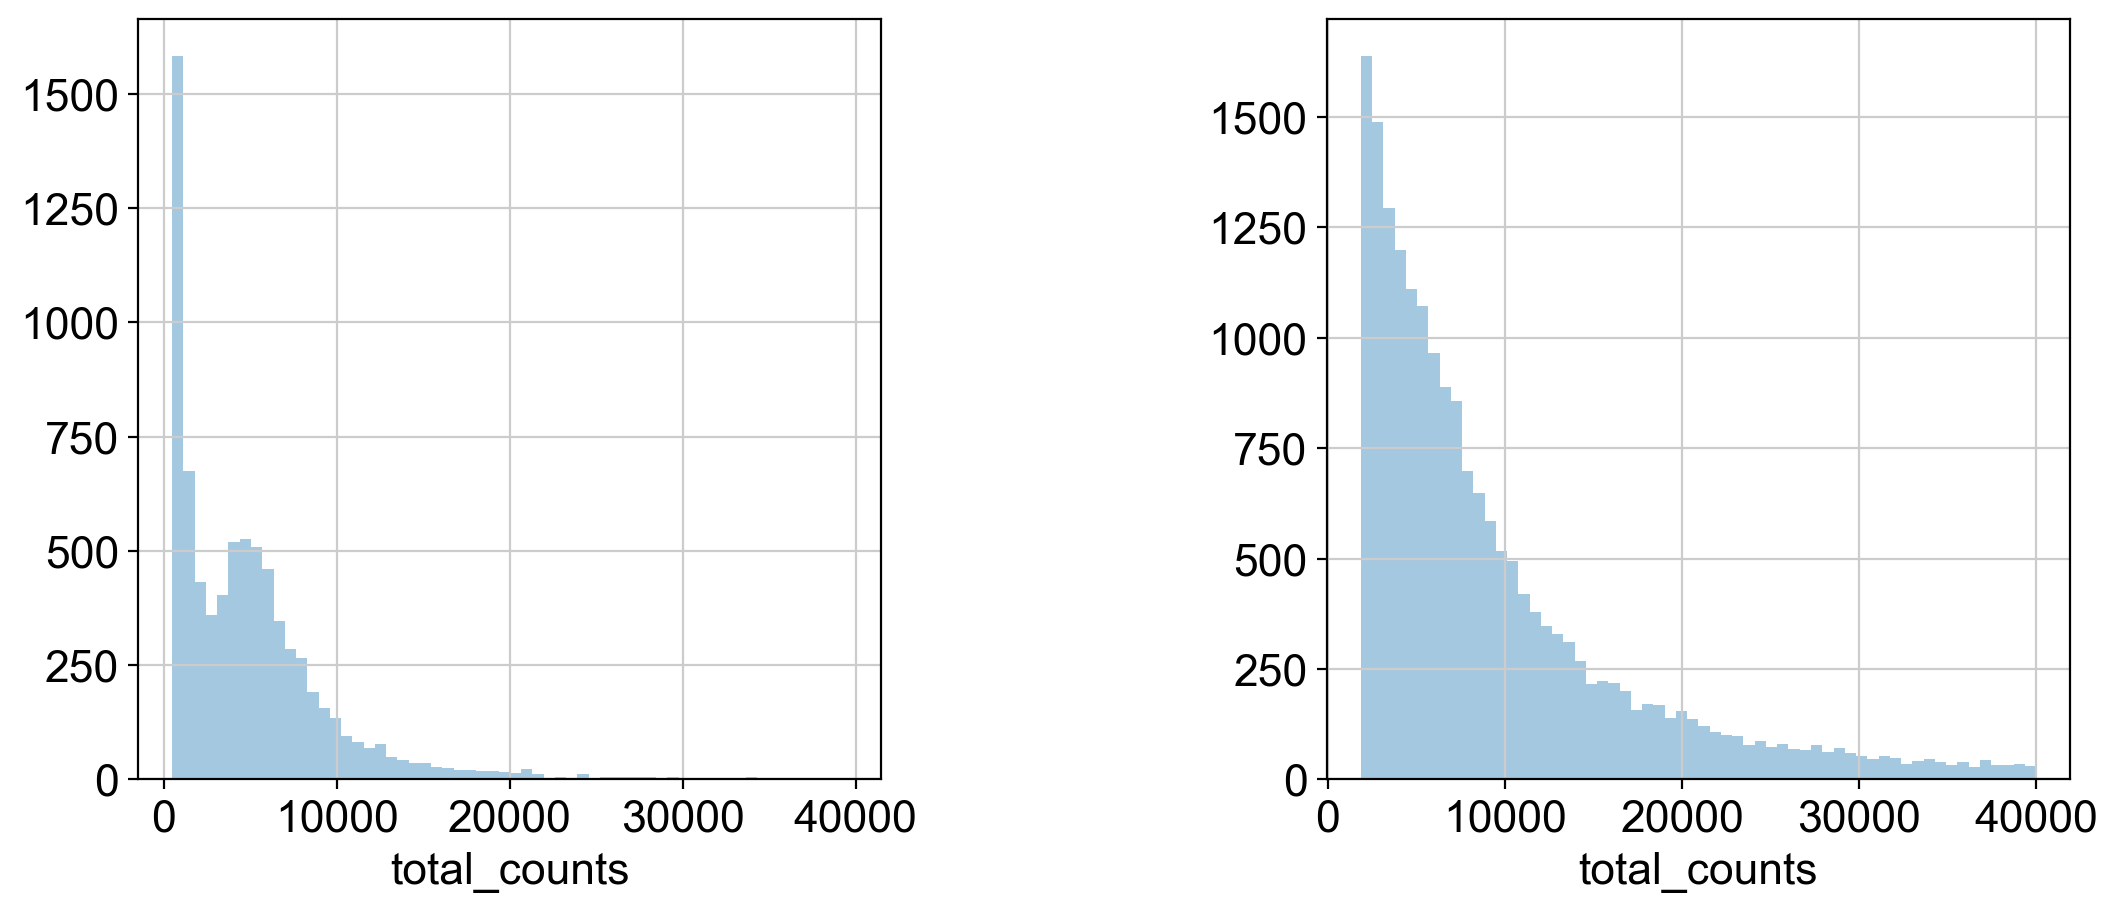

In [53]:
#Thresholding decision: counts
rcParams['figure.figsize']=(20,5)
fig_ind=np.arange(131, 134)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6)

p6 = sb.distplot(adata_4.obs['total_counts'][adata_4.obs['total_counts']<40000], 
                 kde=False, bins=60, 
                 ax=fig.add_subplot(fig_ind[0]))
p7 = sb.distplot(adata_5.obs['total_counts'][adata_5.obs['total_counts']<40000], 
                 kde=False, bins=60, 
                 ax=fig.add_subplot(fig_ind[1]))
plt.show()

/opt/anaconda3/envs/sc-tutorial-020321/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


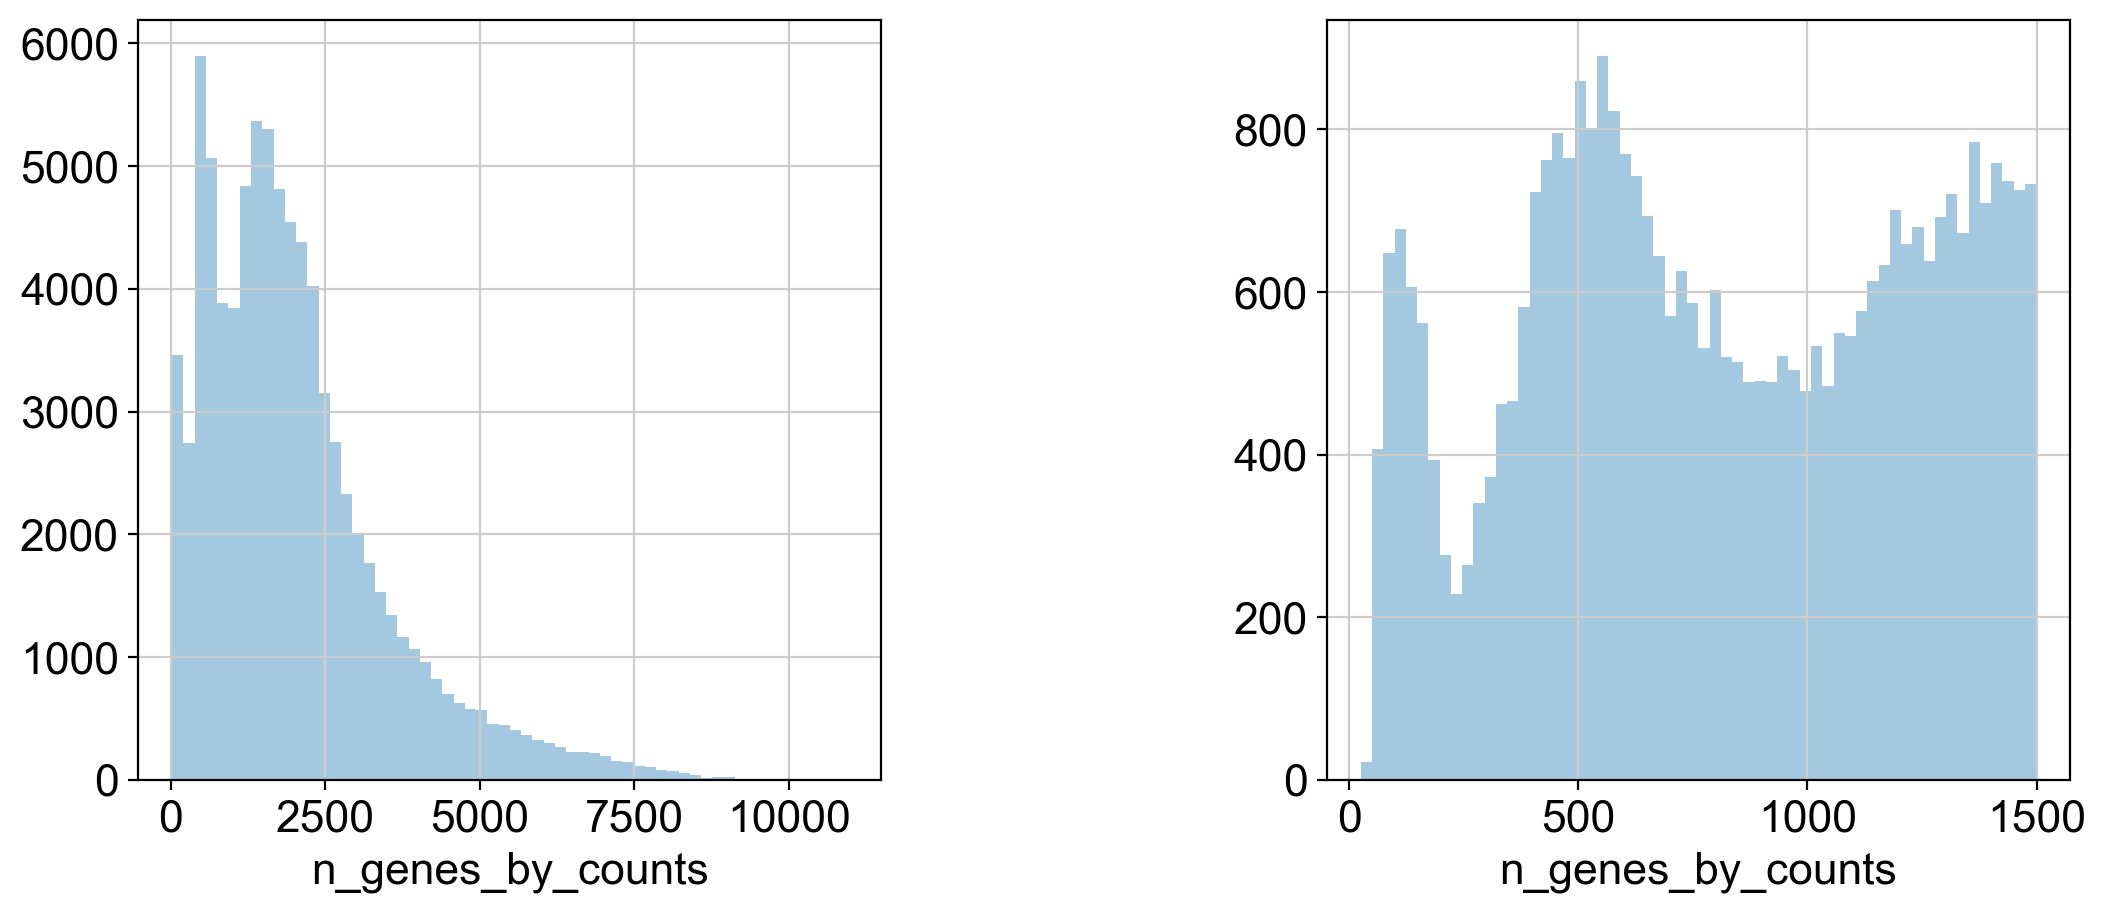

In [54]:
#Thresholding decision: genes

rcParams['figure.figsize']=(20,5)
fig_ind=np.arange(131, 133)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6) #create a grid for subplots

p6 = sb.distplot(adata.obs['n_genes_by_counts'], kde=False, bins=60, ax=fig.add_subplot(fig_ind[0]))

p7 = sb.distplot(adata.obs['n_genes_by_counts'][adata.obs['n_genes_by_counts']<1500], 
                 kde=False, bins=60, ax=fig.add_subplot(fig_ind[1]))
plt.show()

/opt/anaconda3/envs/sc-tutorial-020321/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/sc-tutorial-020321/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/sc-tutorial-020321/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a fi

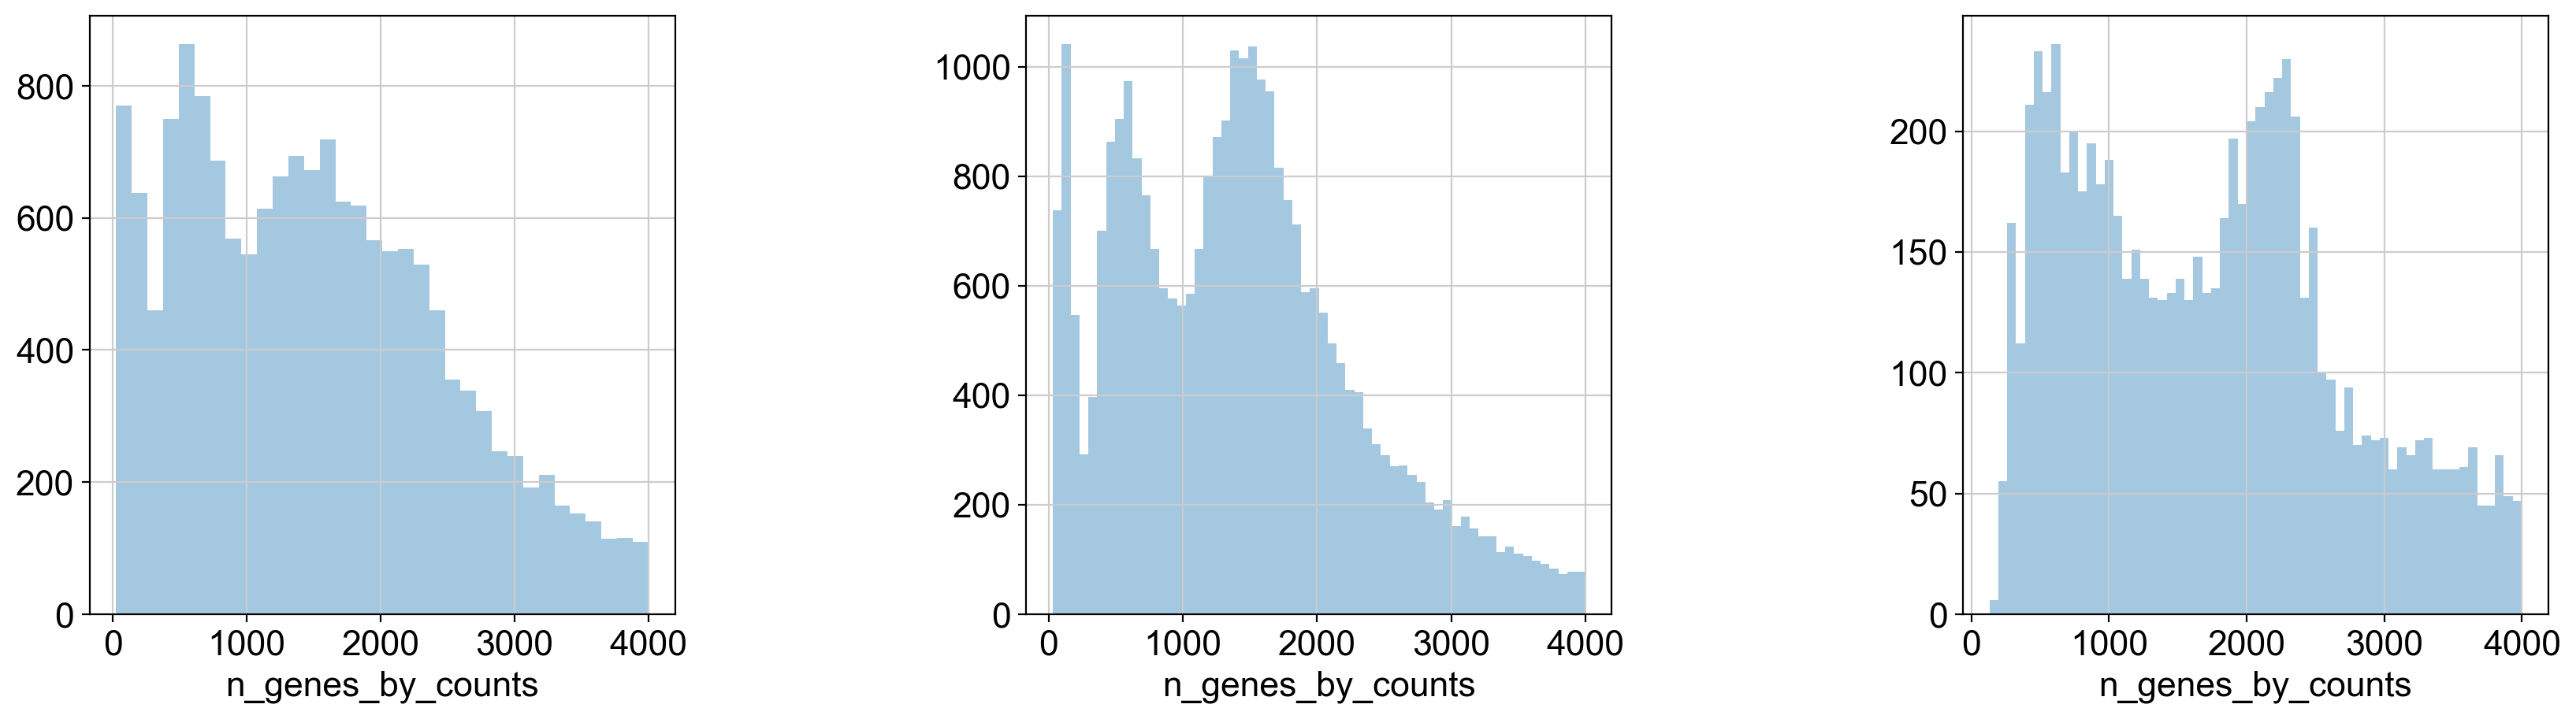

In [55]:
#Thresholding decision: counts
rcParams['figure.figsize']=(20,5)
fig_ind=np.arange(131, 134)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6)

p3 = sb.distplot(adata_1.obs['n_genes_by_counts'][adata_1.obs['n_genes_by_counts']<4000], 
                 kde=False, 
                 ax=fig.add_subplot(fig_ind[0]))
p4 = sb.distplot(adata_2.obs['n_genes_by_counts'][adata_2.obs['n_genes_by_counts']<4000], 
                 kde=False, bins=60, 
                 ax=fig.add_subplot(fig_ind[1]))
p5 = sb.distplot(adata_3.obs['n_genes_by_counts'][adata_3.obs['n_genes_by_counts']<4000], 
                 kde=False, bins=60, 
                 ax=fig.add_subplot(fig_ind[2]))

plt.show()

/opt/anaconda3/envs/sc-tutorial-020321/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/sc-tutorial-020321/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


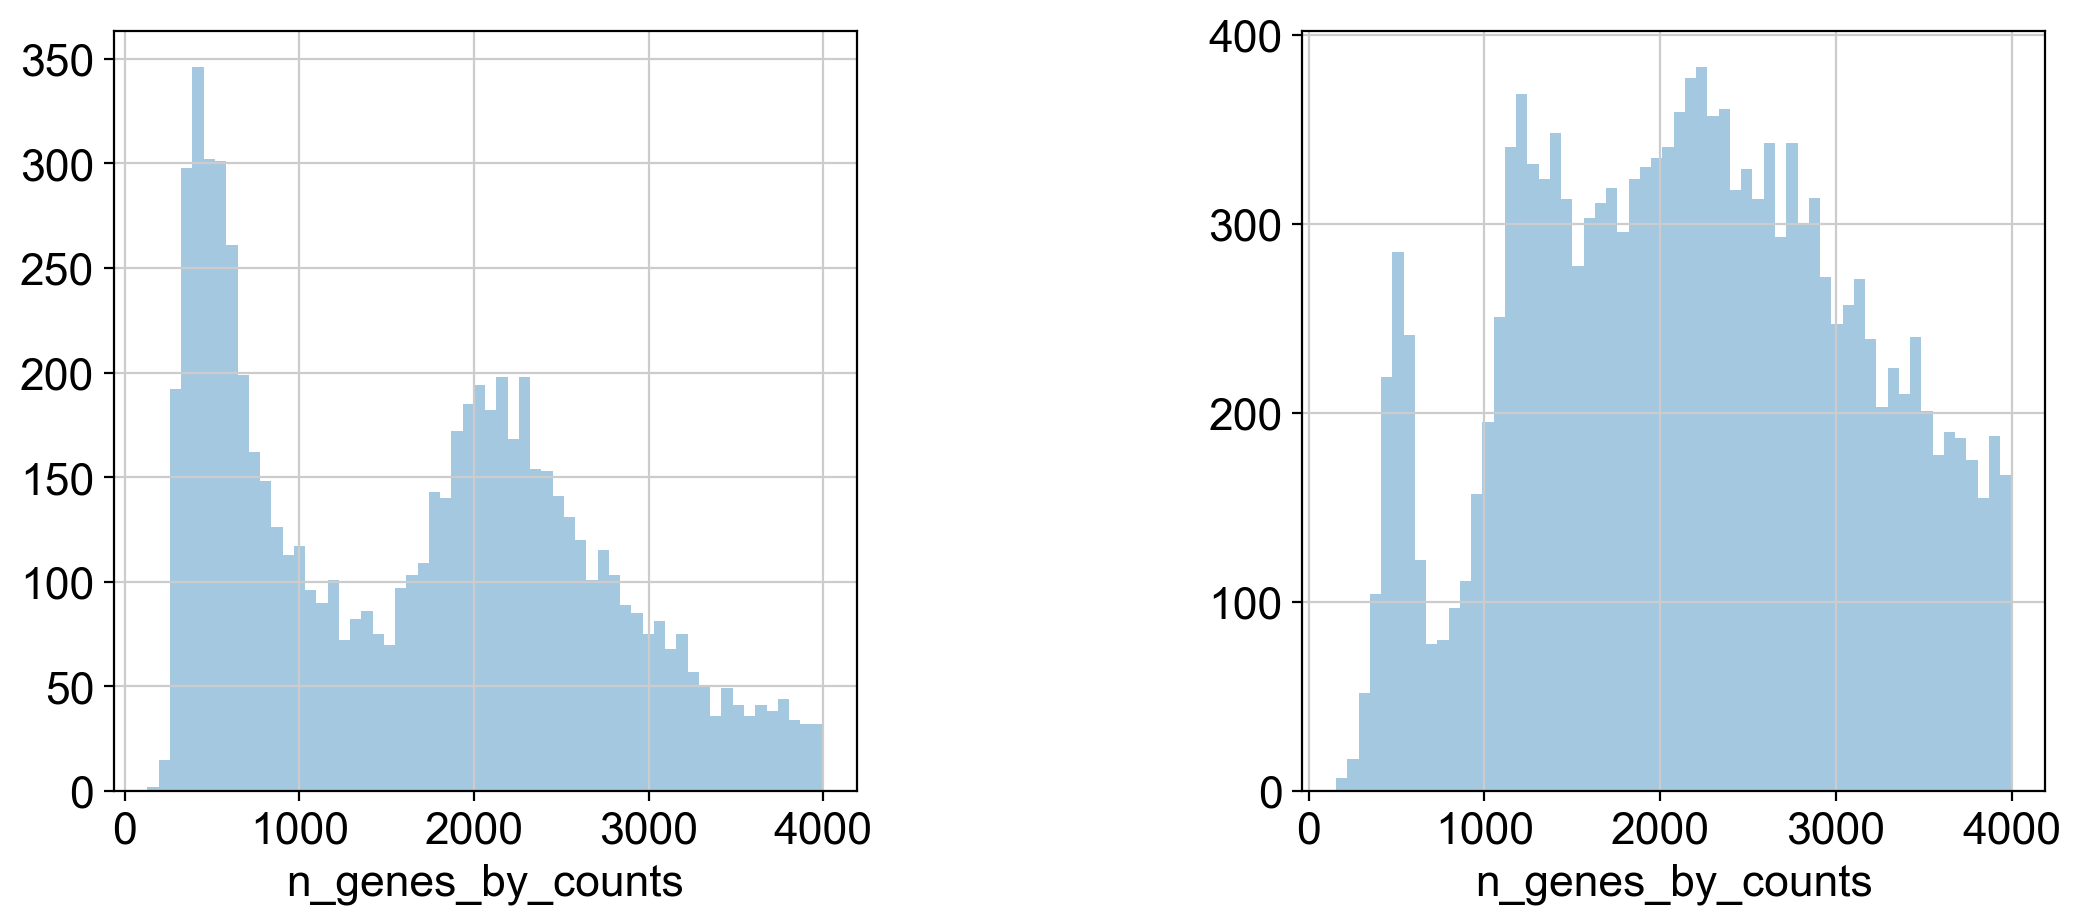

In [56]:
#Thresholding decision: counts
rcParams['figure.figsize']=(20,5)
fig_ind=np.arange(131, 134)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6)

p6 = sb.distplot(adata_4.obs['n_genes_by_counts'][adata_4.obs['n_genes_by_counts']<4000], 
                 kde=False, bins=60, 
                 ax=fig.add_subplot(fig_ind[0]))
p7 = sb.distplot(adata_5.obs['n_genes_by_counts'][adata_5.obs['n_genes_by_counts']<4000], 
                 kde=False, bins=60, 
                 ax=fig.add_subplot(fig_ind[1]))
plt.show()

Create a histogram for the fraction of mitochondrial genes. Further, create a histogram for the high fraction regime, each.

/opt/anaconda3/envs/sc-tutorial-020321/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


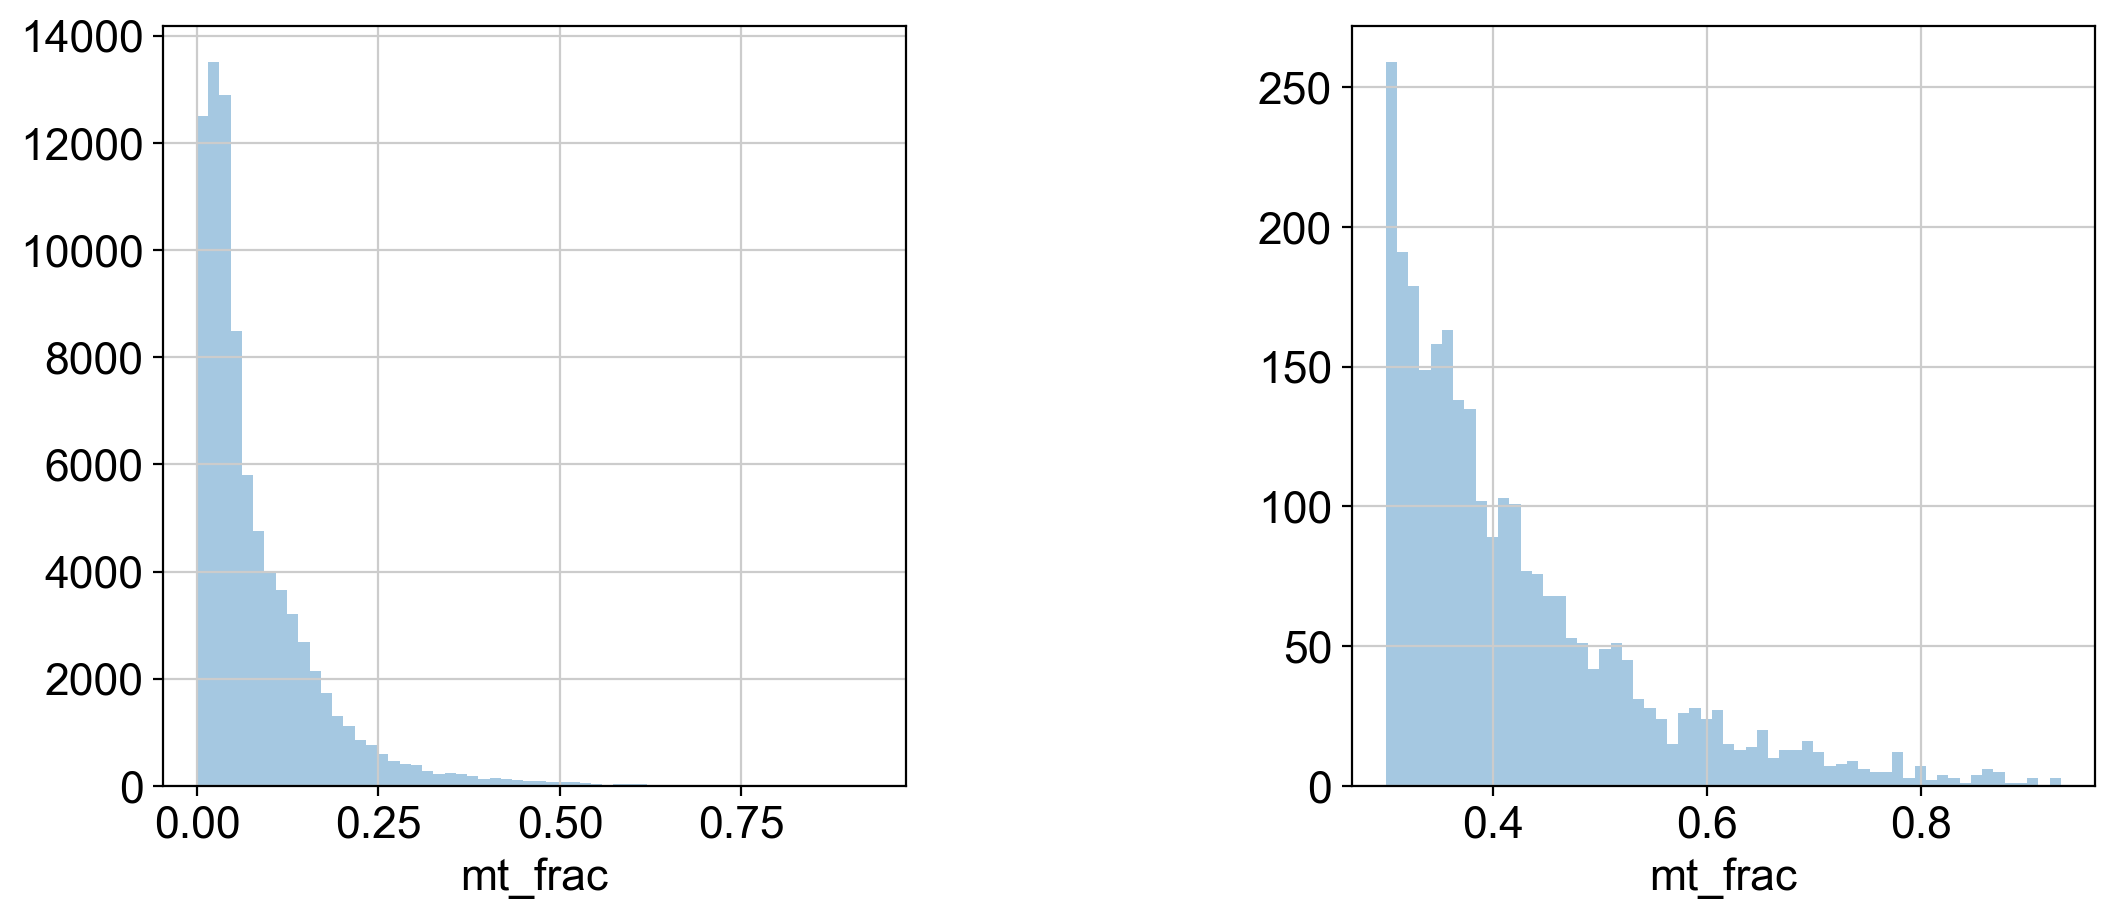

In [57]:
#Thresholding decision: mitochondrial reads

rcParams['figure.figsize']=(20,5)
fig_ind=np.arange(131, 133)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6)

p8 = sb.distplot(adata.obs['mt_frac'], kde=False, bins=60, ax=fig.add_subplot(fig_ind[0]))

p9 = sb.distplot(adata.obs['mt_frac'][adata.obs['mt_frac']>0.3], 
                 kde=False, bins=60, ax=fig.add_subplot(fig_ind[1]))
plt.show()

Filter your cells according for the total number of counts, number of expressed genes and fraction of mitochondrial reads. Check the number of remaining cells after each filtering step.

In [58]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_counts = 50000)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

adata = adata[adata.obs['mt_frac'] < 0.25]
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = 1000)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

Total number of cells: 83833
filtered out 574 cells that have more than 50000 counts
Number of cells after max count filter: 83259
Number of cells after MT filter: 78941
filtered out 19421 cells that have less than 1000 genes expressed


Trying to set attribute `.obs` of view, copying.


Number of cells after gene filter: 59520


Next, filter out non-expressed genes. Check the number of remaining genes after filtering.

In [59]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 27998
filtered out 8708 genes that are detected in less than 20 cells
Number of genes after cell filter: 19290


The filtering is performed based on the thresholds we identified from the QC plots. Genes are also filtered if they are not detected in at least 20 cells. This reduces the dimensions of the matrix by removing 0 count genes and genes which are not sufficiently informative of the dataset.

### Doublet score

Let us estimate the amount of doublets in the dataset.

In [60]:
adata.obs['doublet_score']= np.zeros(adata.shape[0])
adata.obs['doublet'] = np.zeros(adata.shape[0])

In [61]:
# filtering/preprocessing parameters:
min_counts = 2
min_cells = 3
vscore_percentile = 85
n_pc = 50

# doublet detector parameters:
expected_doublet_rate = 0.02 
sim_doublet_ratio = 3
n_neighbors = 15



scrub = scr.Scrublet(counts_matrix = adata.X,  
                     n_neighbors = n_neighbors,
                     sim_doublet_ratio = sim_doublet_ratio,
                     expected_doublet_rate = expected_doublet_rate)

doublet_scores, predicted_doublets = scrub.scrub_doublets( 
                    min_counts = min_counts, 
                    min_cells = min_cells, 
                    n_prin_comps = n_pc,
                    use_approx_neighbors = True, 
                    get_doublet_neighbor_parents = False)

adata.obs['doublet_score'] = doublet_scores
adata.obs['doublet'] = predicted_doublets


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.13
Detected doublet rate = 1.5%
Estimated detectable doublet fraction = 45.3%
Overall doublet rate:
	Expected   = 2.0%
	Estimated  = 3.3%
Elapsed time: 82.6 seconds


/opt/anaconda3/envs/sc-tutorial-020321/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


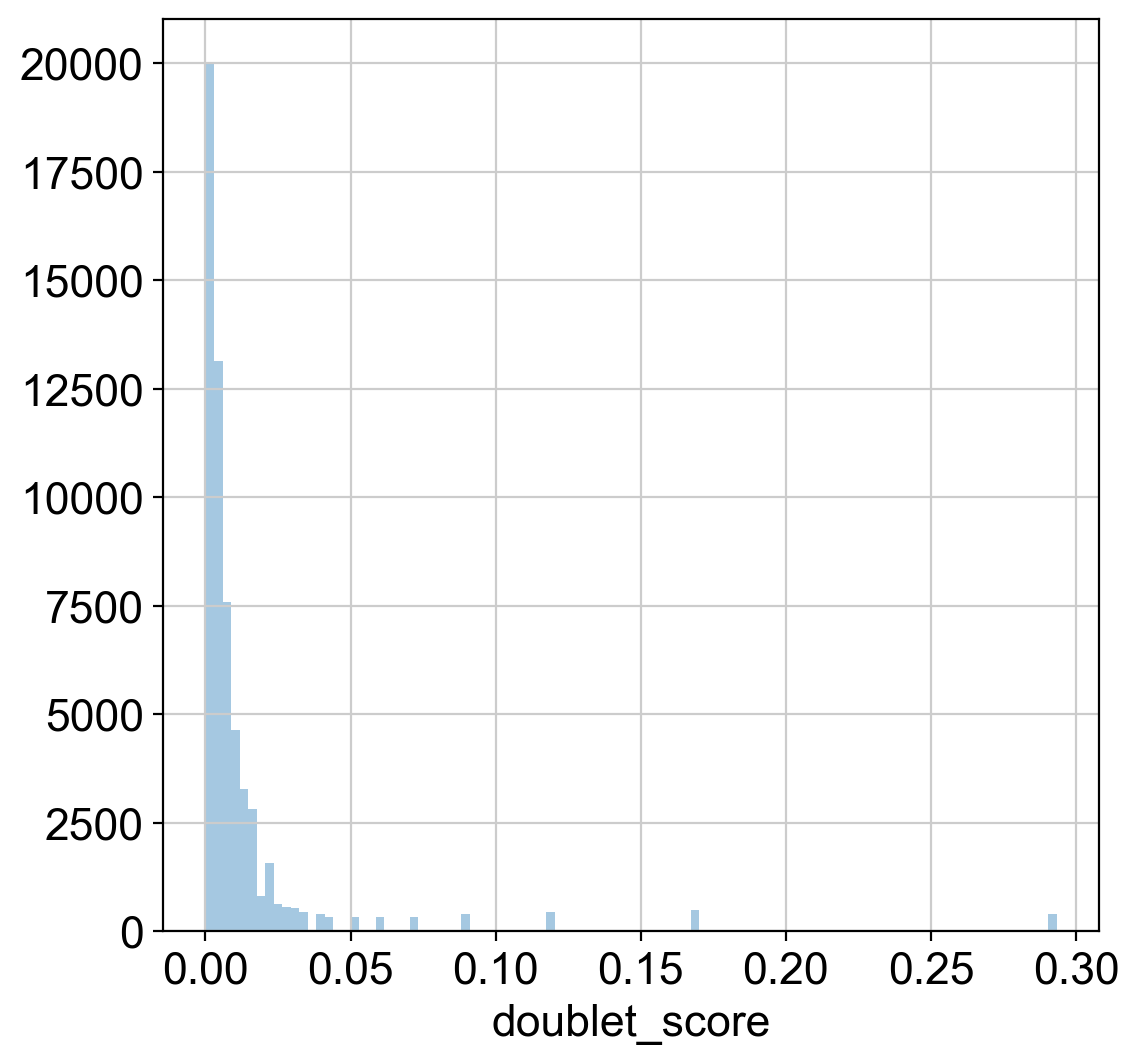

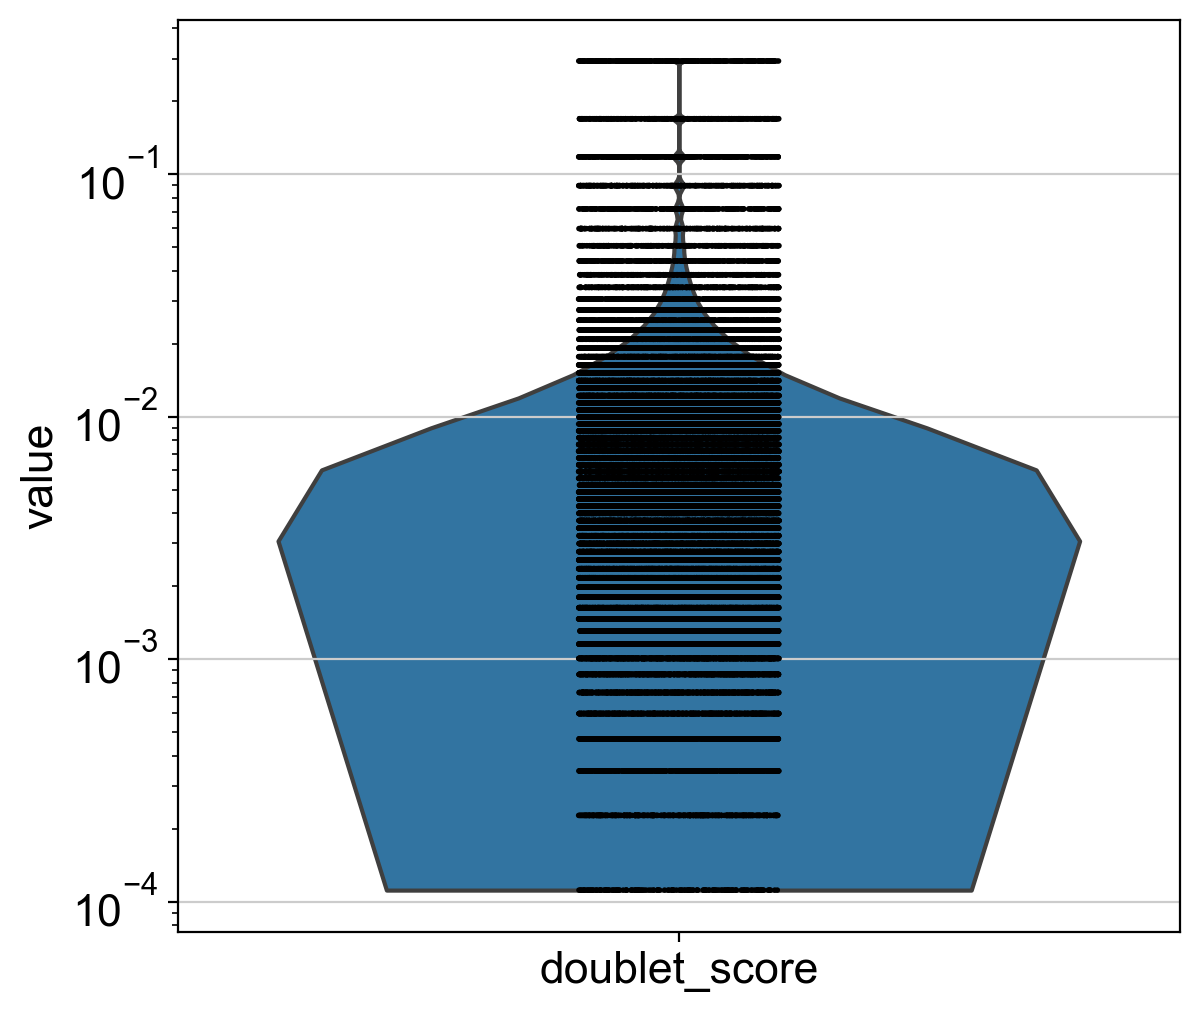

In [62]:
rcParams['figure.figsize']=(6,6)
sb.distplot(adata.obs['doublet_score'], bins=100, kde=False)
plt.show()


sc.pl.violin(adata, 'doublet_score',
                  size=2, log=True, cut=0)

/opt/anaconda3/envs/sc-tutorial-020321/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/sc-tutorial-020321/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


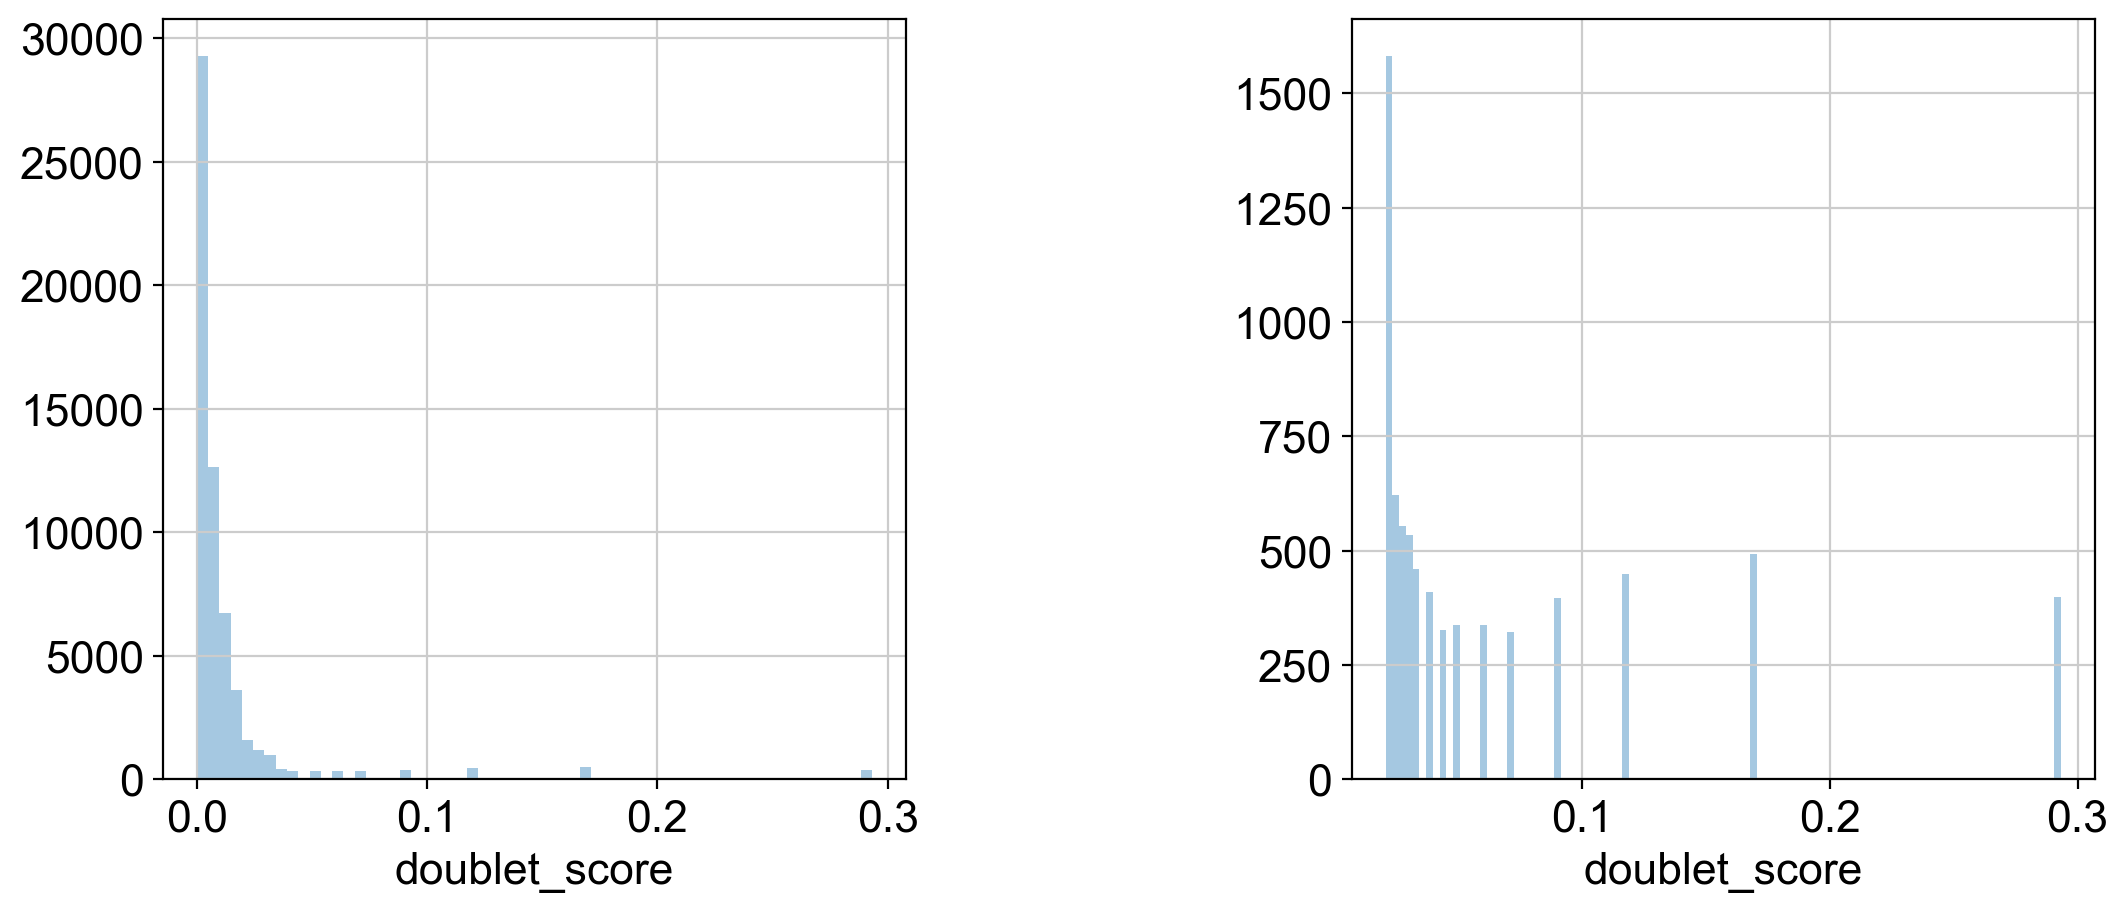

In [63]:
rcParams['figure.figsize']=(20,5)
fig_ind=np.arange(131, 133)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6)

p8 = sb.distplot(adata.obs['doublet_score'], kde=False, bins=60, ax=fig.add_subplot(fig_ind[0]))

p9 = sb.distplot(adata.obs['doublet_score'][adata.obs['doublet_score']>0.02], 
                 kde=False, bins=100, ax=fig.add_subplot(fig_ind[1]))
plt.show()

### filtering doublets

Scrublet proposed a different threshold than we would choose based upon the histogram plot of the doublet scores.

In [64]:
thr = 0.05
ix_filt = adata.obs['doublet_score']<=thr

adata = adata[ix_filt].copy()
print('Number of cells after doublet filter: {:d}'.format(adata.n_obs))

Number of cells after doublet filter: 56786


### Summarize sample information

In order to group by `batch` (for future purposes, because we presently deal with one sample), let us add a `batch` covariate to the `adata` object. 

In [65]:
adata

AnnData object with n_obs × n_vars = 56786 × 19290
    obs: 'sample_id', 'sample_id_str', 'condition', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'n_counts', 'n_genes', 'doublet_score', 'doublet'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'sample_id_str_colors'

In [66]:
adata.obs['condition'] = adata.obs['sample_id_str'].map(sample_id_str2condition).astype('category')

In [67]:
#dooble check annotation
pd.crosstab(adata.obs['sample_id_str'],adata.obs['condition'])

condition            3dpi_CTRL  3dpi_INT  5dpi_CTRL  5dpi_INH   INT
sample_id_str                                                      
21L008532_5dpi_CTRL          0         0       8308         0     0
21L008533_5dpi_INH           0         0          0      7910     0
MUC13715_5dpi_CTRL           0         0       5874         0     0
MUC13721_INT                 0         0          0         0  2676
MUC13722_3dpi_CTRL        1850         0          0         0     0
MUC13723_3dpi_CTRL        1796         0          0         0     0
MUC13724_3dpi_INH            0      1867          0         0     0
MUC13725_3dpi_INH            0      2750          0         0     0
MUC13726_INT                 0         0          0         0  2474
MUC13727_5dpi_CTRL           0         0       1716         0     0
MUC13729_5dpi_INH            0         0          0      3836     0
MUC13730_5dpi_INH            0         0          0      3914     0
MUC13731_INT                 0         0          0         0  3389
MUC13732_INT                 0         0          0         0  3766
MUC29190_INT                 0         0          0         0  4660

In [68]:
set(adata.obs['sample_id_str'])

{'21L008532_5dpi_CTRL',
 '21L008533_5dpi_INH',
 'MUC13715_5dpi_CTRL',
 'MUC13721_INT',
 'MUC13722_3dpi_CTRL',
 'MUC13723_3dpi_CTRL',
 'MUC13724_3dpi_INH',
 'MUC13725_3dpi_INH',
 'MUC13726_INT',
 'MUC13727_5dpi_CTRL',
 'MUC13729_5dpi_INH',
 'MUC13730_5dpi_INH',
 'MUC13731_INT',
 'MUC13732_INT',
 'MUC29190_INT'}

In [69]:
df = adata.obs[['n_genes_by_counts','total_counts', 'batch']]
df_all = pd.DataFrame(df.groupby(by='batch')['n_genes_by_counts'].apply(np.mean).values,
                      index=df.groupby(by='batch')['n_genes_by_counts'].apply(np.mean).index,
                      columns=['mean_genes'])

df_all['median_genes']=df.groupby(by='batch')['n_genes_by_counts'].apply(np.median).values
df_all['mean_counts']=df.groupby(by='batch')['total_counts'].apply(np.mean).values
df_all['median_counts']=df.groupby(by='batch')['total_counts'].apply(np.median).values
df_all

mean_genes  median_genes   mean_counts  median_counts
batch                                                        
1      2317.128805        2031.0   7608.946289         5359.0
2      2023.408484        1744.0   5566.244141         4170.0
3      2595.687606        2265.0   7955.892578         4924.5
4      2517.510300        2289.0   7031.278320         5657.5
5      3140.014367        2765.0  10681.934570         7406.0

In [64]:
df_all.to_csv(table_dir + today+'data_overview_earlytp.csv')

Save filtered data to file.

In [71]:
adata.write(data_dir +today+ 'data_postQC_all_earlytp.h5ad', compression='gzip')

In [70]:
data_dir

'/Volumes/bzb/JN/Jovica/Manuscript_CK_VS/notebooks/Read_data_QC/'

In [72]:
today+ 'data_postQC_all_earlytp.h5ad'

'230216data_postQC_all_earlytp.h5ad'

In [68]:
adata = sc.read(data_dir+"230216data_postQC_all_earlytp.h5ad")

## 2.3 Normalization

In [89]:
rcParams['figure.figsize']=(5,5)

In [73]:
#Keep the count data in a counts layer
adata.layers["counts"] = adata.X.copy()

In [74]:
#Perform a clustering for scran normalization in clusters
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)
sc.tl.louvain(adata_pp, key_added='groups', resolution=0.5)

normalizing by total count per cell
    finished (0:00:04): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA
    with n_comps=15
    finished (0:00:13)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:07)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 22 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:15)


In [91]:
sc.pl.pca(adata_pp,color='total_counts')
sc.pl.pca(adata_pp,color='groups')
sc.pl.pca(adata_pp,color='sample_id')

NameError: name 'adata_pp' is not defined

In [76]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata.X.T

In [77]:
%%R -i data_mat -i input_groups -o size_factors
#need to wrap the "computeSumFactors(data_mat, clusters=input_groups, min.mean=0.1)" call due to version change in Bioconductor 3.11,
#see issue discussion in: https://github.com/theislab/scib/issues/141
size_factors = BiocGenerics::sizeFactors(
                      scran::computeSumFactors(
                            SingleCellExperiment::SingleCellExperiment(list(
                                  counts=data_mat
                            ))
                          )
                        )


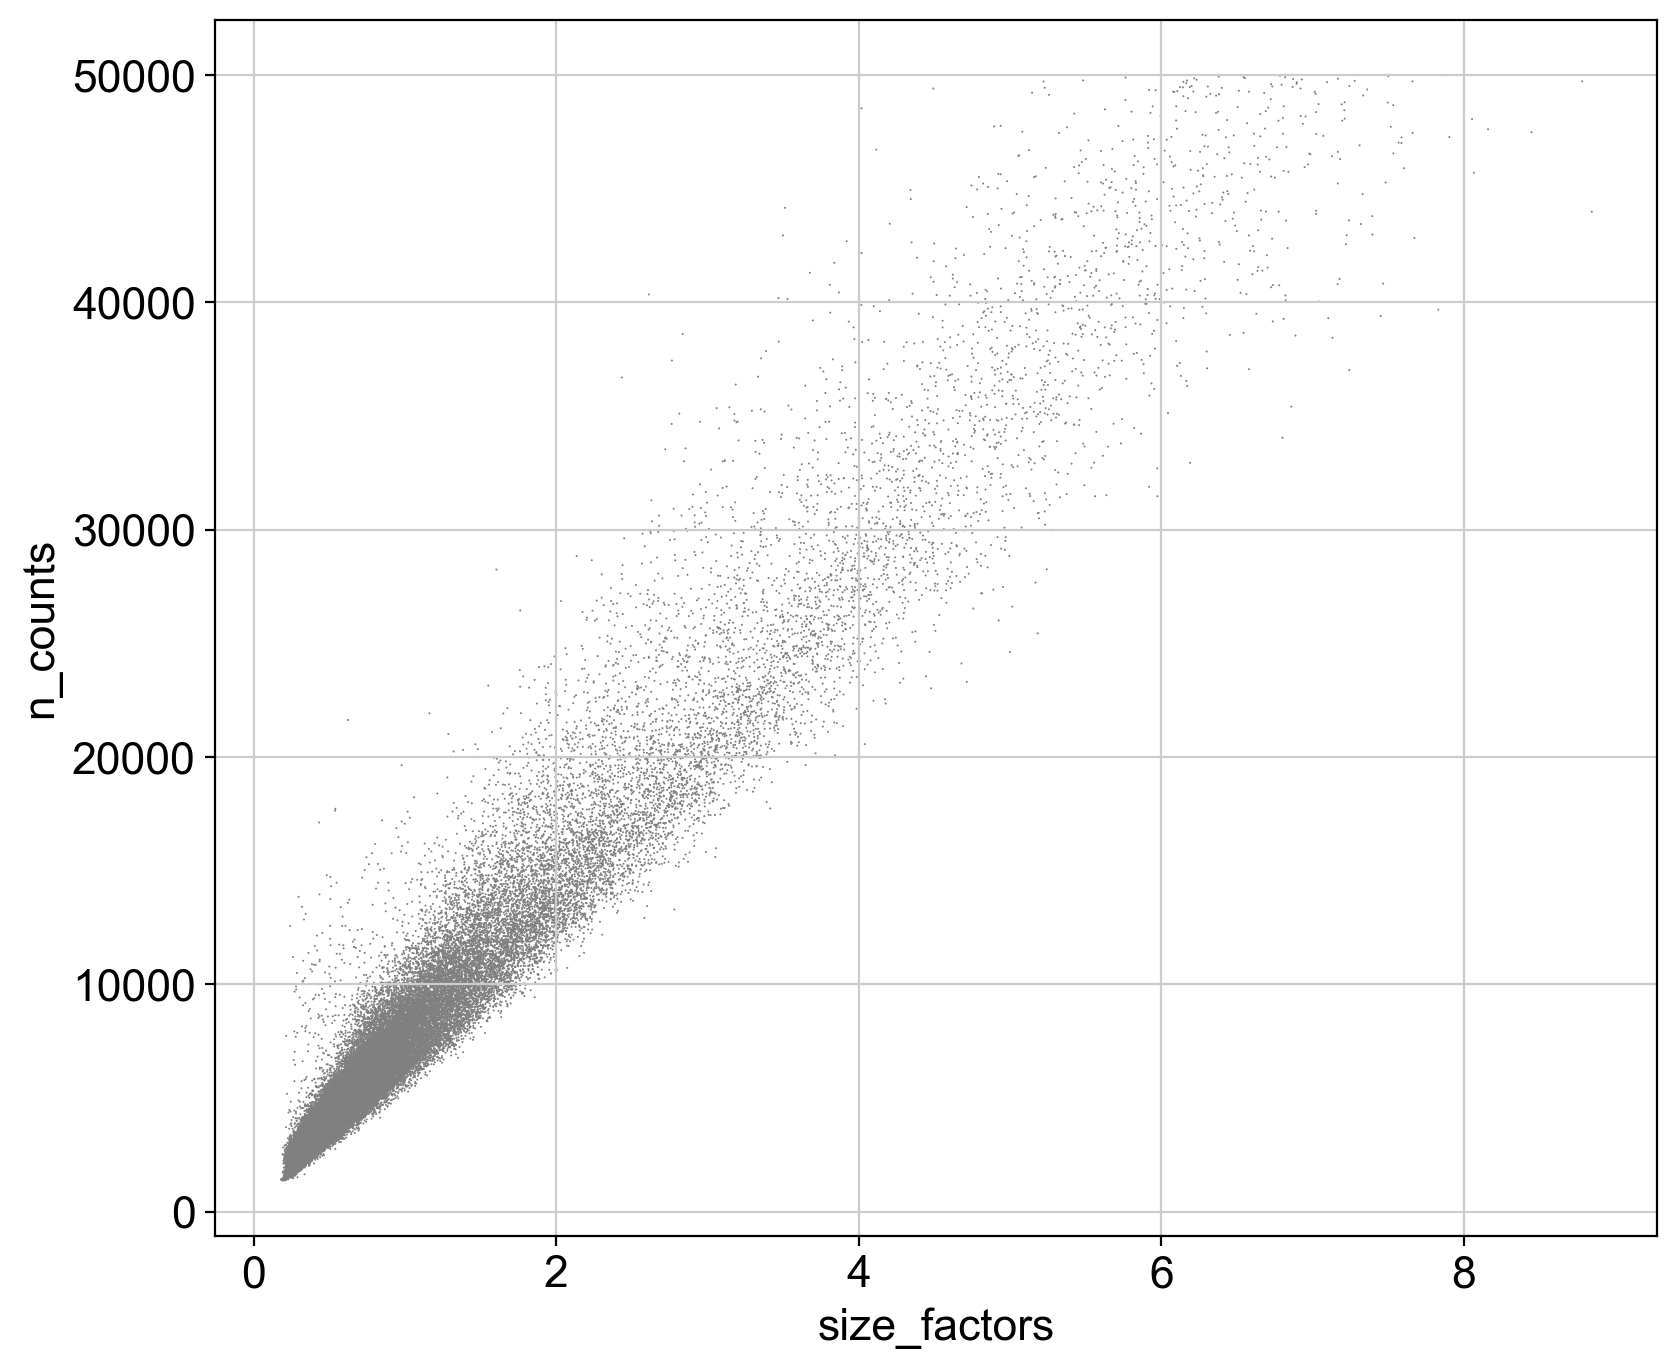

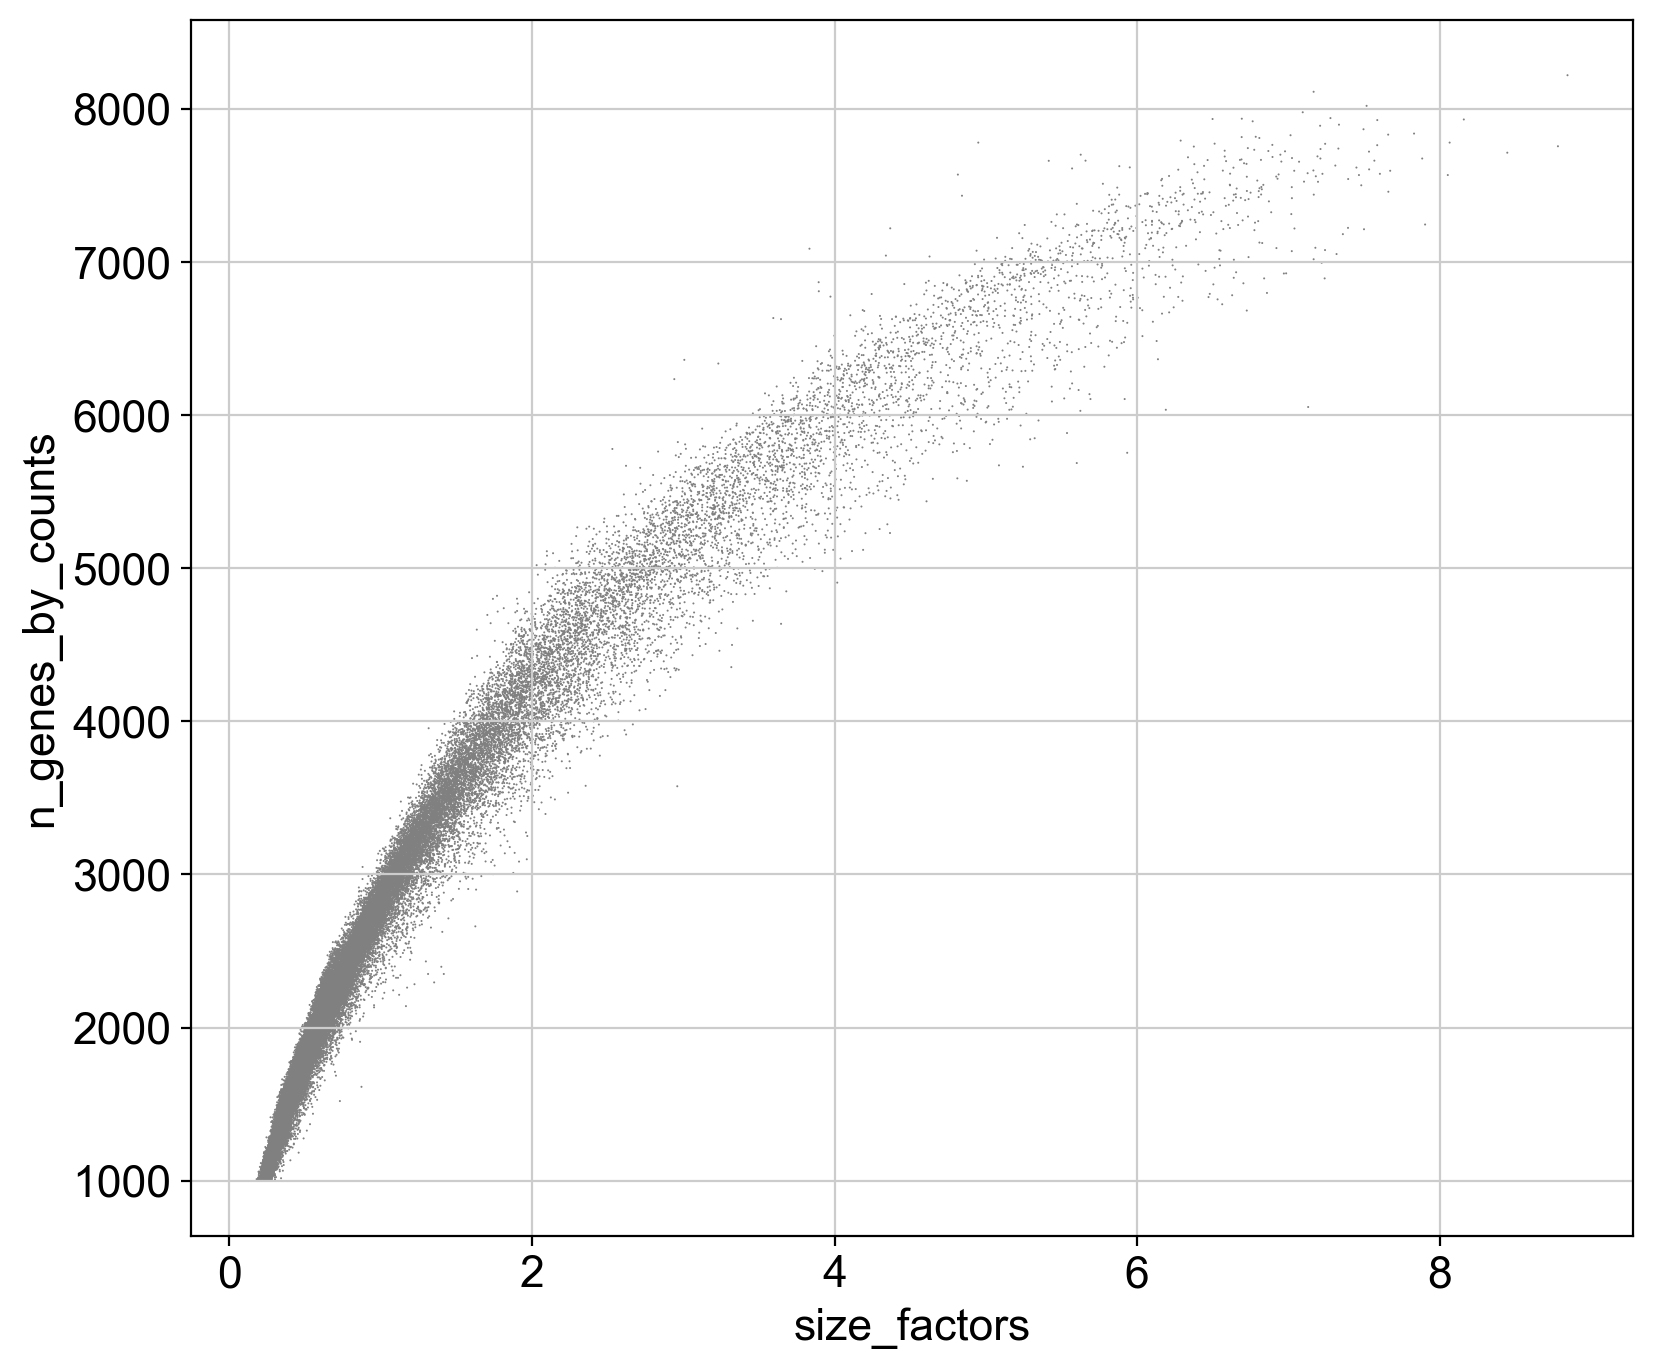

In [78]:
# Visualize the estimated size factors
adata.obs['size_factors'] = size_factors
adata_pp.obs['size_factors'] = size_factors

rcParams['figure.figsize']=(8,8)
sc.pl.scatter(adata, 'size_factors', 'n_counts')
sc.pl.scatter(adata, 'size_factors', 'n_genes_by_counts')

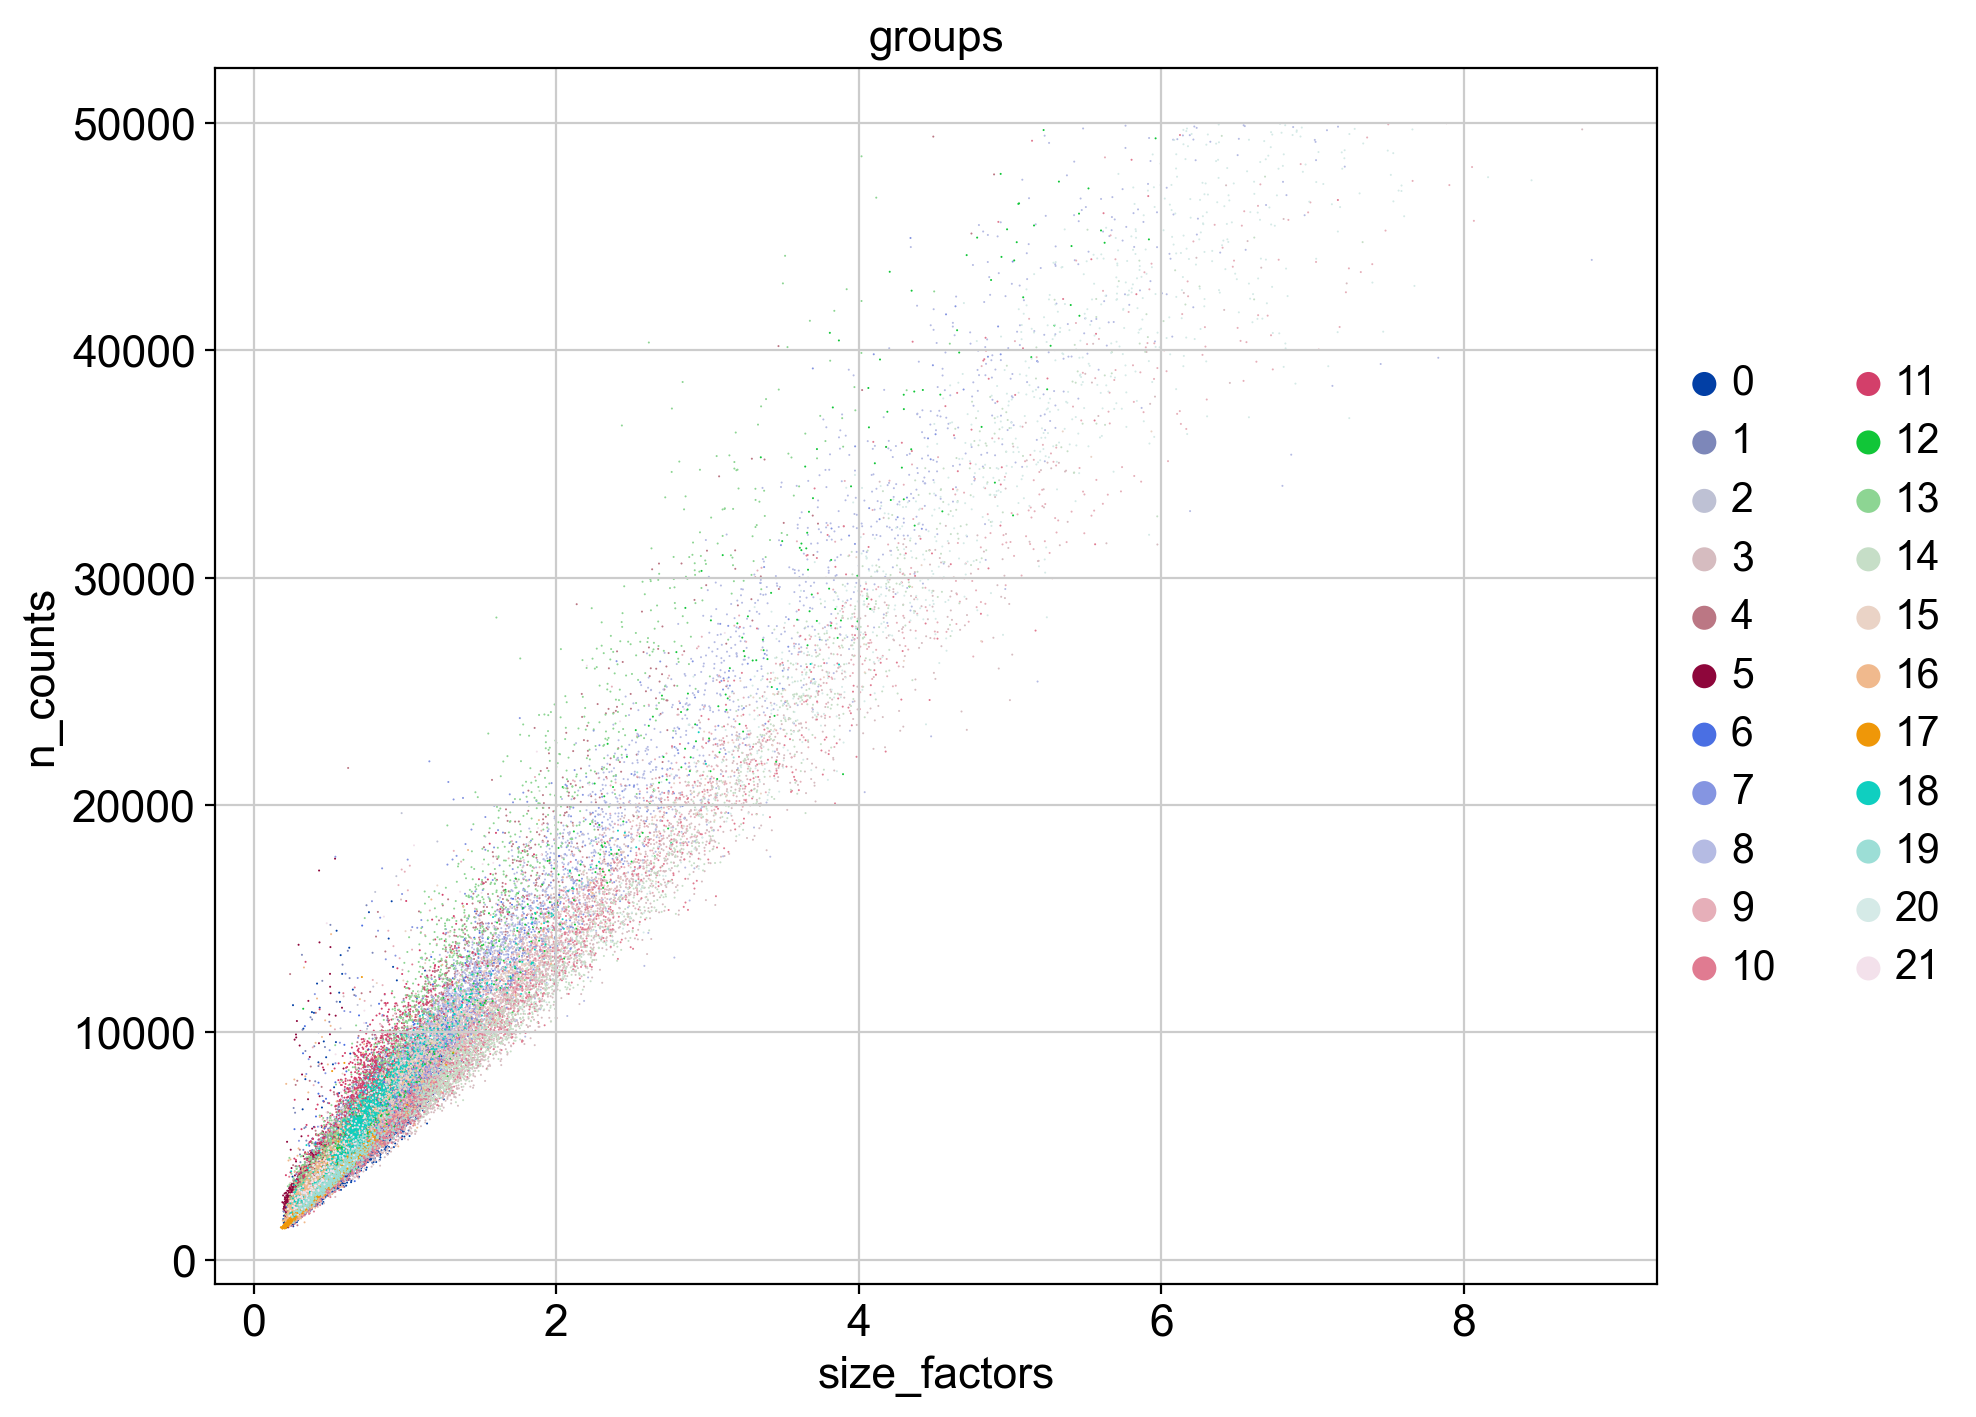

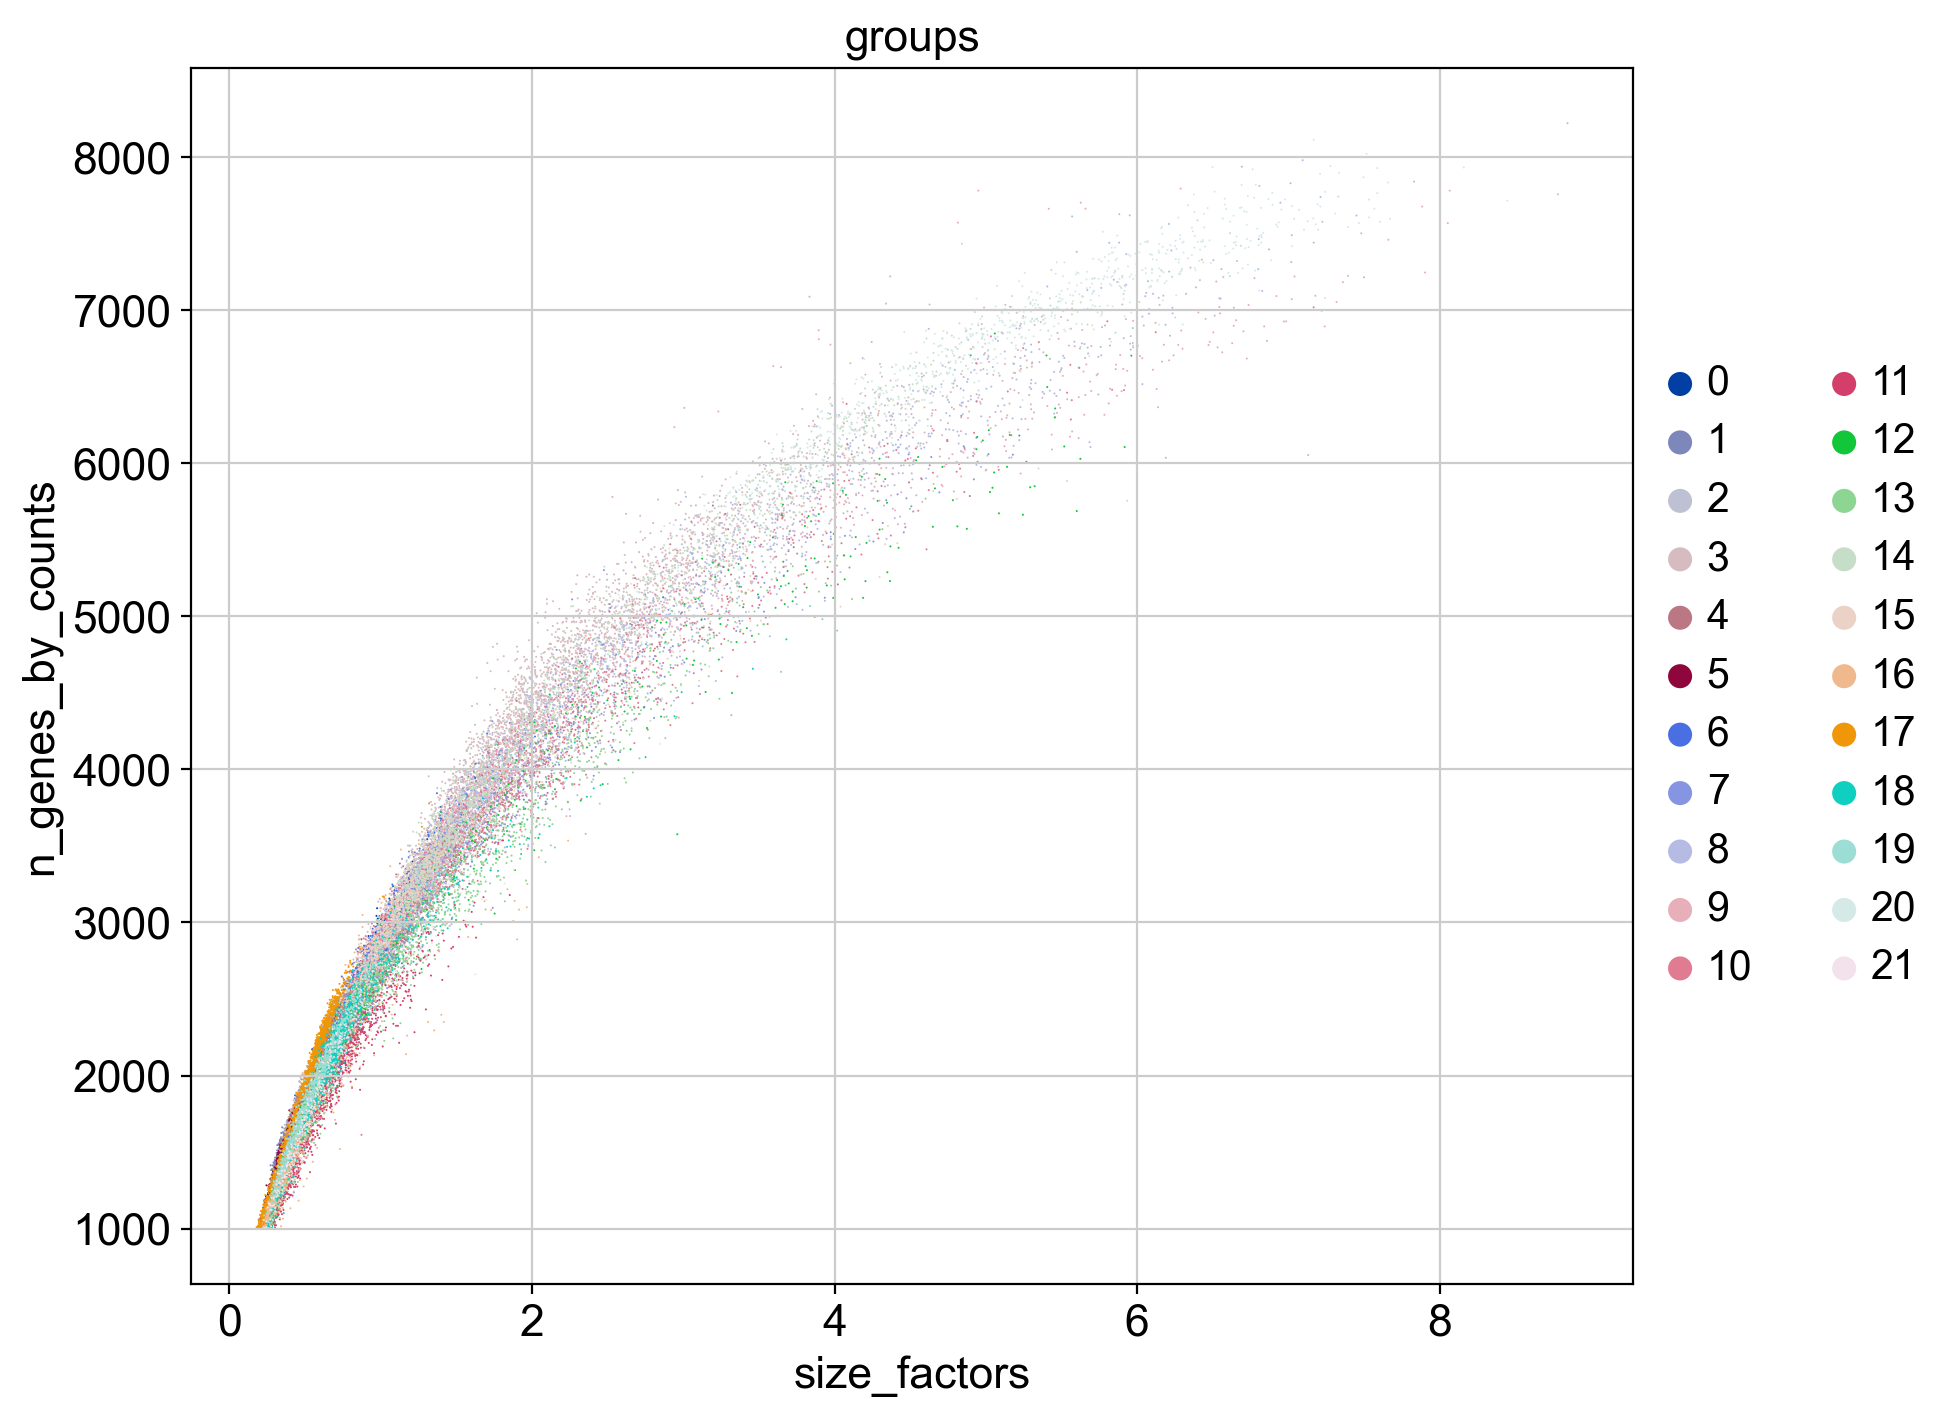

In [79]:
sc.pl.scatter(adata_pp, 'size_factors', 'n_counts', color='groups')
sc.pl.scatter(adata_pp, 'size_factors', 'n_genes_by_counts', color='groups')

/opt/anaconda3/envs/sc-tutorial-020321/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


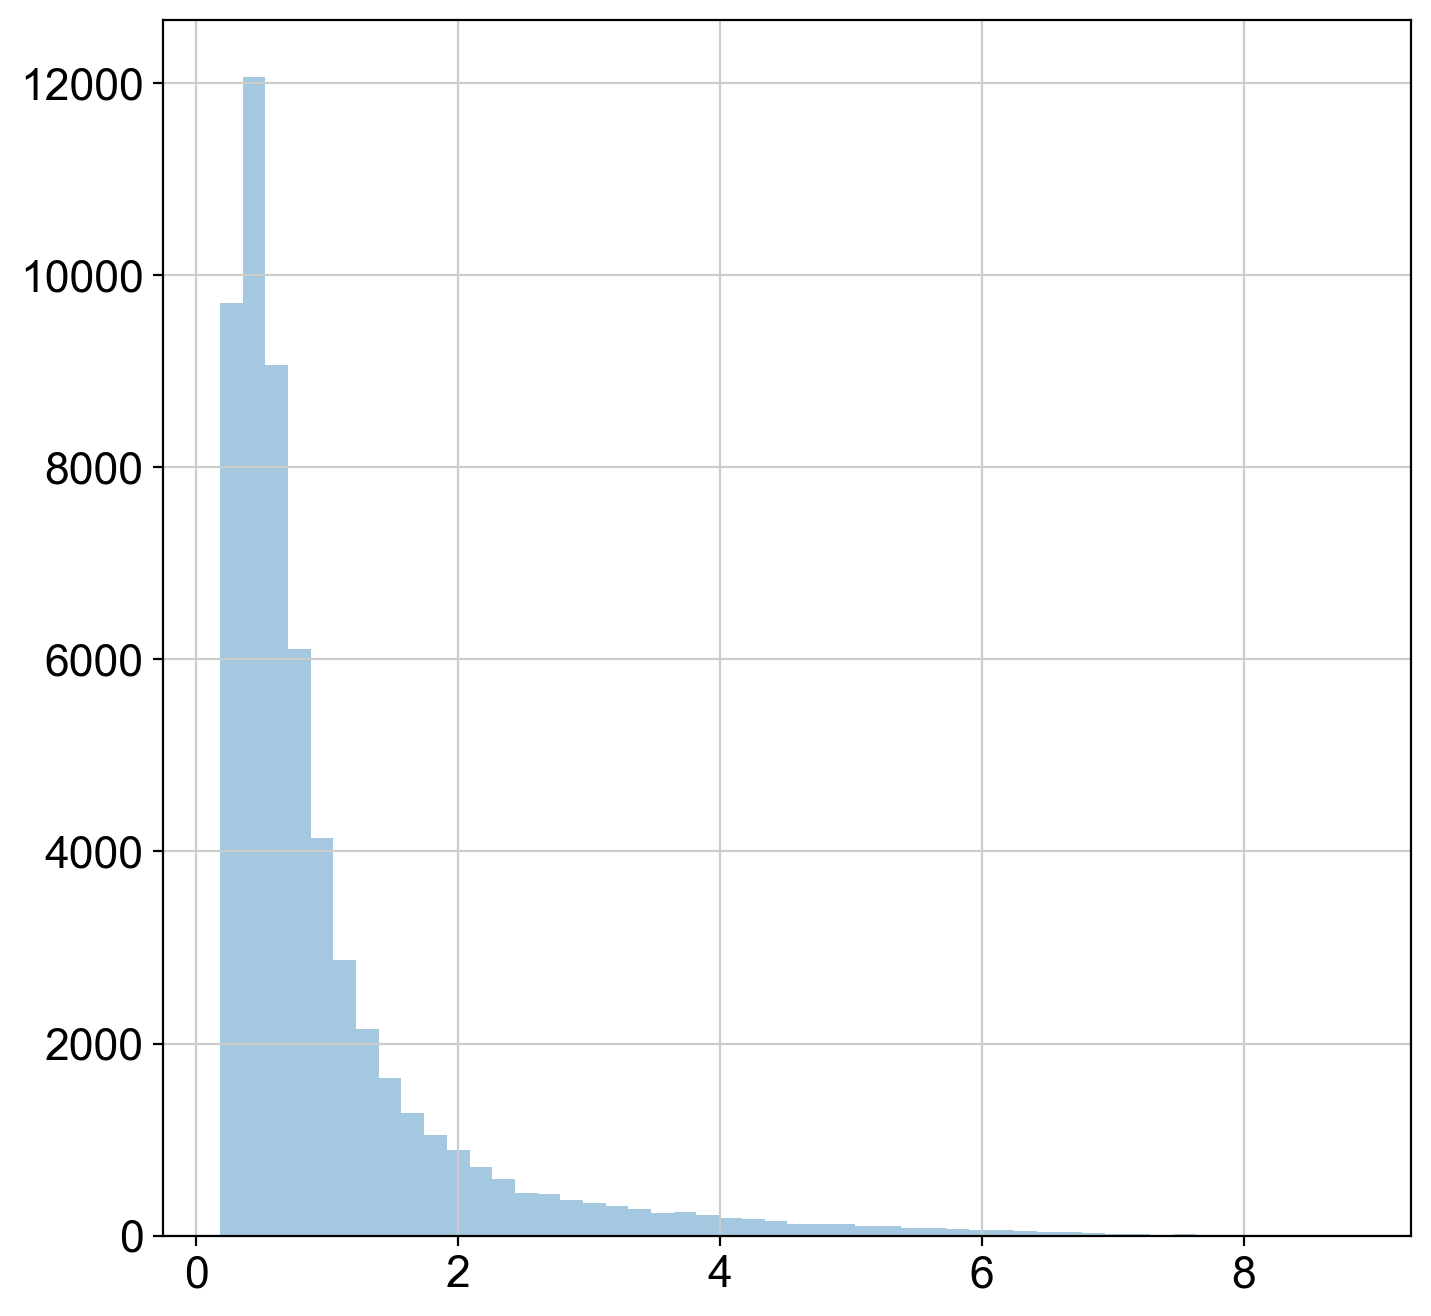

In [80]:
sb.distplot(size_factors, bins=50, kde=False)
plt.show()

Normalize with scran size-factors and log-scale. 

In [81]:
adata.X /= adata.obs['size_factors'].values[:,None]
sc.pp.log1p(adata)

Modify the format of the resulting data matrix.

In [82]:
adata.X = np.asarray(adata.X)

Free memory.

In [83]:
del adata_pp

Of note, we convert the gene expression matrix X to the sparse format to memory.

In [84]:
import scipy.sparse as sparse

In [85]:
adata.X = sparse.csr_matrix(adata.X)

In [86]:
adata.raw = adata.copy()

In [87]:
#Keep the count data in a counts layer
adata.layers["counts_lognorm"] = adata.X.copy()

In [88]:
adata

AnnData object with n_obs × n_vars = 56786 × 19290
    obs: 'sample_id', 'sample_id_str', 'condition', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'n_counts', 'n_genes', 'doublet_score', 'doublet', 'size_factors'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'sample_id_str_colors', 'log1p'
    layers: 'counts', 'counts_lognorm'

In [90]:
adata.write(data_dir +today+ 'data_postnorm_all_earlytp.h5ad', compression='gzip') #220302data_postnorm_all_earlytp.h5ad

In [87]:
today+ 'data_postnorm_all_earlytp.h5ad'

'220505data_postnorm_all_earlytp.h5ad'